In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive
import os
from joblib import load, dump

In [2]:
import tensorflow as tf

print("Versión de TensorFlow:", tf.__version__)

# Verificar si hay GPUs disponibles en Colab
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} GPUs físicas, {len(logical_gpus)} GPUs lógicas")
        print("¡GPU detectada y configurada para crecimiento de memoria!")
    except RuntimeError as e:
        print(e)
else:
    print("¡No se detectó ninguna GPU! Se usará la CPU.")


Versión de TensorFlow: 2.18.0
1 GPUs físicas, 1 GPUs lógicas
¡GPU detectada y configurada para crecimiento de memoria!


In [3]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/json/'

years = range(2017, 2026)

all_stations = set()

print("Recolectando todas las estaciones únicas de todos los años")
for year in years:
    file_path = os.path.join(base_path, f"{year}.csv")
    try:
        df_temp = pd.read_csv(file_path, usecols=['indicativo'])
        all_stations.update(df_temp['indicativo'].unique())
        print(f"  - Procesado {year}. Estaciones únicas encontradas hasta ahora: {len(all_stations)}")
    except FileNotFoundError:
        print(f"Advertencia: Archivo {file_path} no encontrado. Saltando este año.")
    except Exception as e:
        print(f"Error al leer {file_path}: {e}")

all_stations_list = sorted(list(all_stations))
print(f"\nNúmero total de estaciones únicas encontradas en todos los años: {len(all_stations_list)}")

# Ajustar el LabelEncoder con TODAS las estaciones únicas
global_label_encoder = LabelEncoder()
global_label_encoder.fit(all_stations_list) # Ajusta el encoder con todas las estaciones

# Guarda este LabelEncoder global
encoder_save_path = os.path.join(base_path, 'label_encoder_global_all_stations.joblib')
dump(global_label_encoder, encoder_save_path)
print(f"LabelEncoder global ajustado con todas las estaciones y guardado en: {encoder_save_path}")

print("Proceso completado")

Mounted at /content/drive
--- Recolectando todas las estaciones únicas de todos los años ---
  - Procesado 2017. Estaciones únicas encontradas hasta ahora: 870
  - Procesado 2018. Estaciones únicas encontradas hasta ahora: 876
  - Procesado 2019. Estaciones únicas encontradas hasta ahora: 888
  - Procesado 2020. Estaciones únicas encontradas hasta ahora: 891
  - Procesado 2021. Estaciones únicas encontradas hasta ahora: 901
  - Procesado 2022. Estaciones únicas encontradas hasta ahora: 907
  - Procesado 2023. Estaciones únicas encontradas hasta ahora: 918
  - Procesado 2024. Estaciones únicas encontradas hasta ahora: 918
  - Procesado 2025. Estaciones únicas encontradas hasta ahora: 918

Número total de estaciones únicas encontradas en todos los años: 918
LabelEncoder global ajustado con todas las estaciones y guardado en: /content/drive/MyDrive/json/label_encoder_global_all_stations.joblib

--- Proceso completado. Ahora puedes usar este LabelEncoder global en tus scripts anuales. ---


df_total cargado desde CSV con 309965 filas y 25 columnas.
df_total ya cargado con 309965 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309965 entries, 0 to 309964
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       309965 non-null  object 
 1   indicativo  309965 non-null  object 
 2   nombre      309965 non-null  object 
 3   provincia   309965 non-null  object 
 4   altitud     309965 non-null  int64  
 5   tmed        304499 non-null  object 
 6   prec        302521 non-null  object 
 7   tmin        304581 non-null  object 
 8   tmax        304609 non-null  object 
 9   hrMax       294920 non-null  float64
 10  horaHrMax   294804 non-null  object 
 11  hrMin       294920 non-null  float64
 12  horaHrMin   294824 non-null  object 
 13  hrMedia     295126 non-null  float64
dtypes: float64(3), int64(1), object(10)
memory usage: 33.1+ MB

--- Ordenando Datos Globalmente por Fecha

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Entrenamiento del Modelo (Año 2017) ---
Tamaño del conjunto de entrenamiento para `fit`: 183153 muestras
Tamaño del conjunto de validación para `fit`: 20351 muestras
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
2862/2862 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - loss: 0.4576 - mae: 0.4320 - val_loss: 0.0081 - val_mae: 0.0723 - learning_rate: 5.0000e-04
Epoch 2/50
2862/2862 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 0.0062 - mae: 0.0627 - val_loss: 0.0046 - val_mae: 0.0544 - learning_rate: 5.0000e-04
Epoch 3/50
2862/2862 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 0.0046 - mae: 0.0535 - val_loss: 0.0030 - val_mae: 0.0428 - learning_rate: 5.0000e-04
Epoch 4/50
2862/2862 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 0.0040 - 

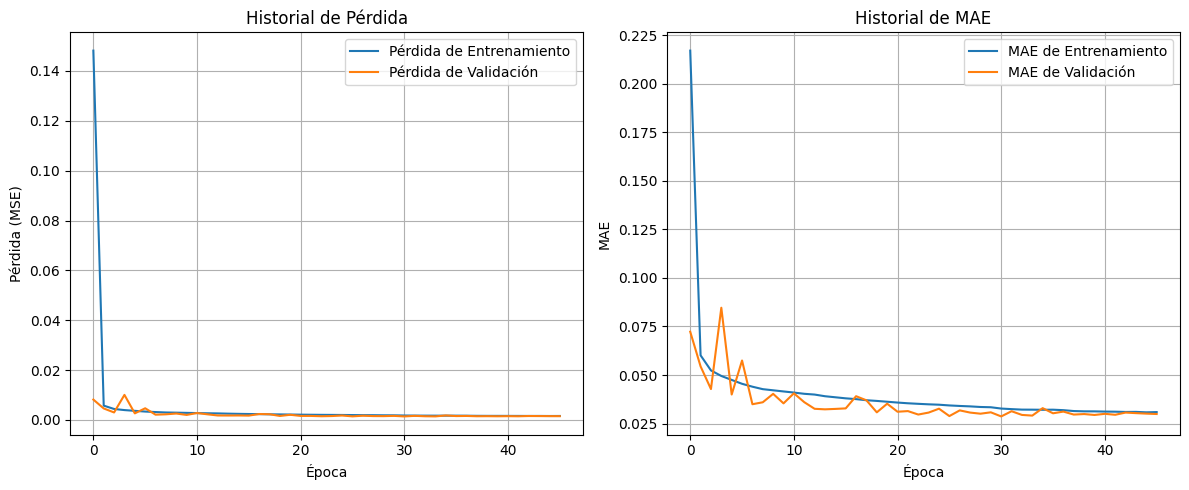


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 9.86°C, Real: 7.80°C
Predicción: 8.44°C, Real: 9.40°C
Predicción: 10.08°C, Real: 9.00°C
Predicción: 11.50°C, Real: 10.00°C
Predicción: 11.86°C, Real: 11.60°C
Predicción: 12.83°C, Real: 12.00°C
Predicción: 12.68°C, Real: 12.40°C
Predicción: 14.58°C, Real: 12.90°C
Predicción: 14.55°C, Real: 12.00°C
Predicción: 13.96°C, Real: 13.60°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0016
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0296
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.43°C
Coeficiente de Determinación (R-squared) (completo): 0.8898

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


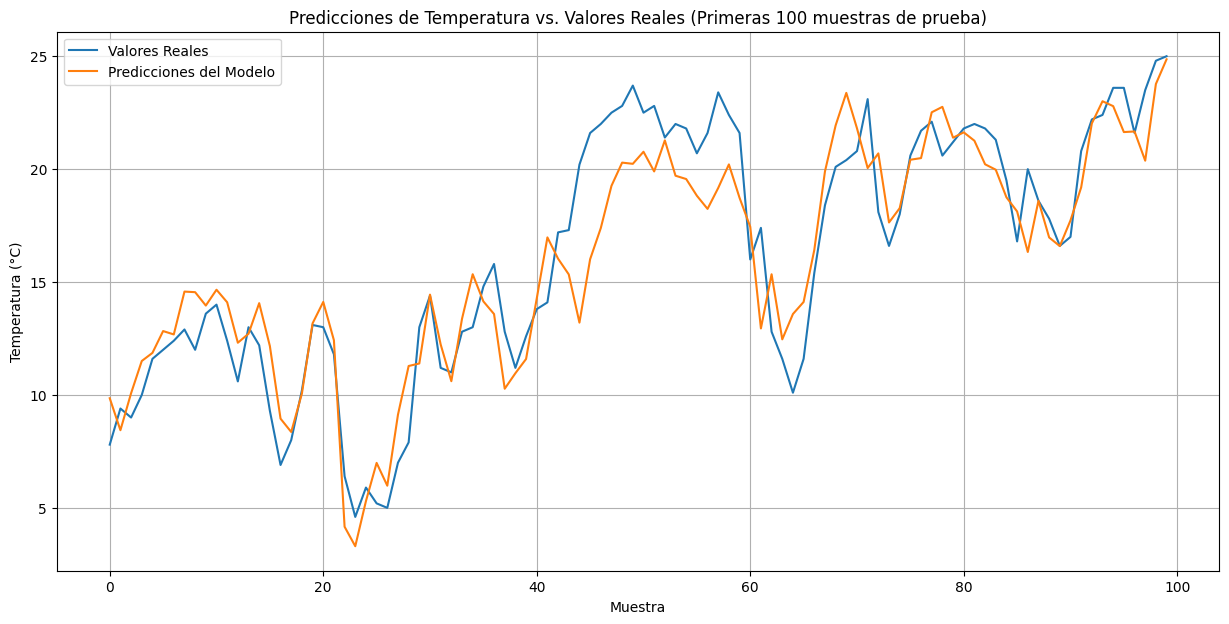


--- Gráfico de Pérdida MSE (Completo) ---


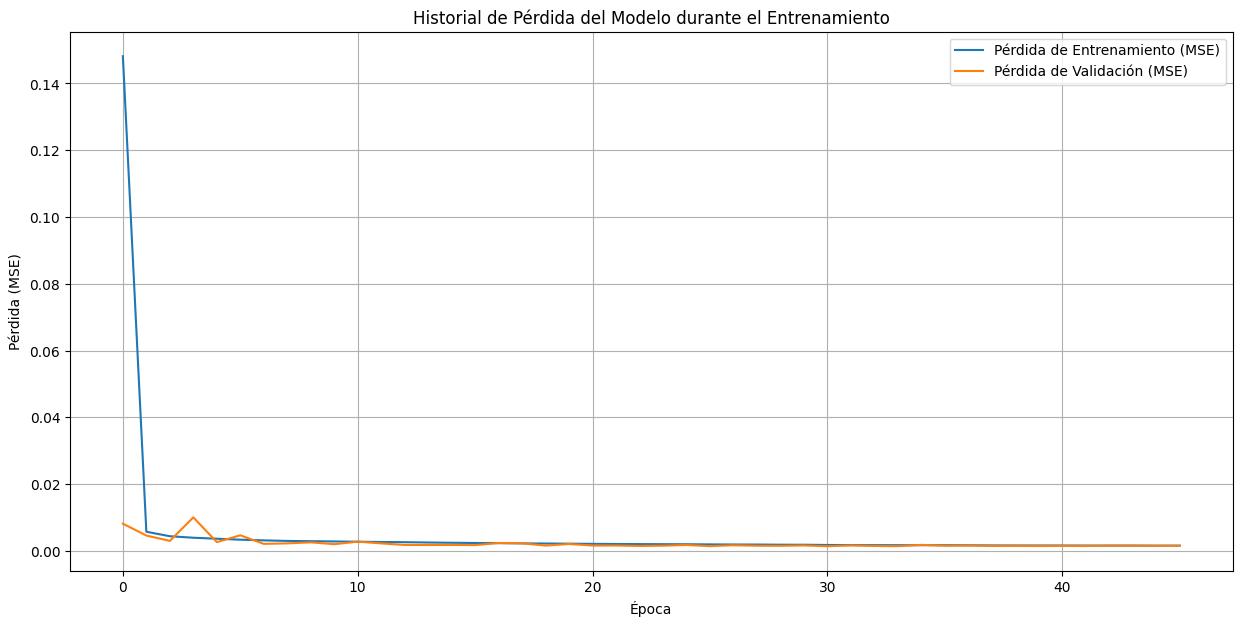


--- Gráfico MAE (Completo) ---


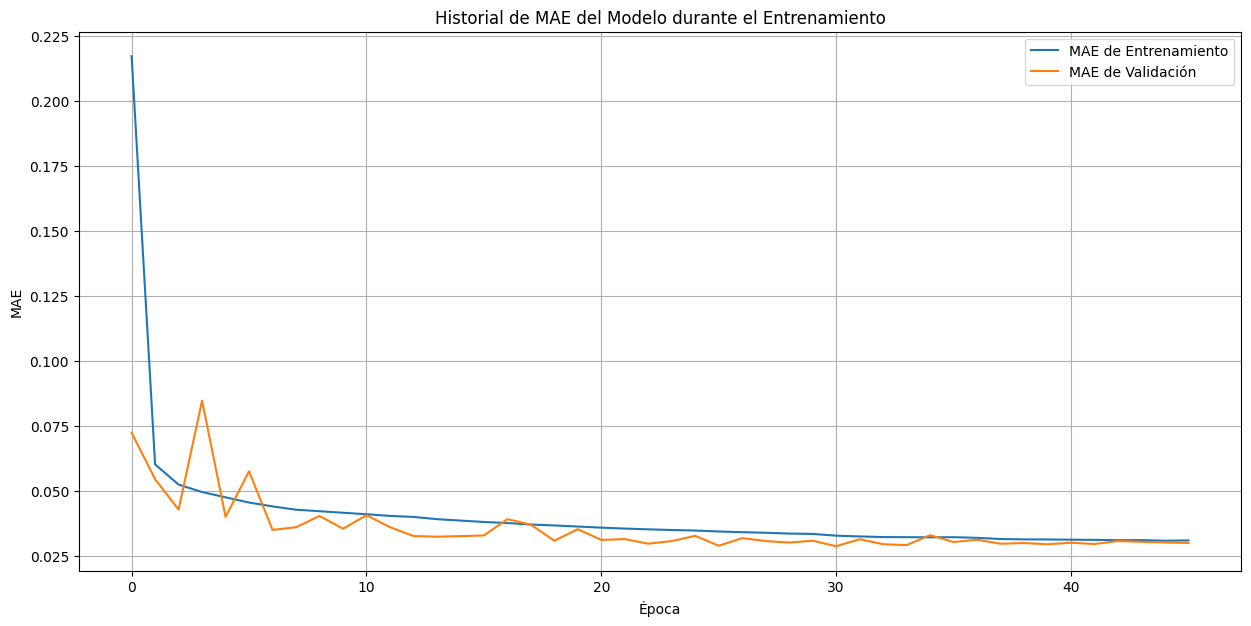


--- Guardando el modelo en: /content/drive/MyDrive/json/2017-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [5]:
# Carga y Preprocesamiento de Datos (2017) ACA HAY QUE CAMBIAR EL AÑO DEL CSV

df_total = pd.read_csv('/content/drive/MyDrive/json/2017.csv')

print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")

# Columnas a eliminar. Nunca eliminar tmed, asi tenemos algo en comun para poder unir todo despues
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]

df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')

#  CONFIGURACIÓN GLOBAL PARA LOS ENTRENAMIENTOS!!! NO CAMVBIAR NADA, PORQUE DESPUÉS NO VOY A PODER HACER LA UNIÓN
TIME_STEPS = 50

print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()


print(" Ordenando Datos Globalmente por Fecha y Estación ") # NO SAQUEN LOS PRINTS QUE ME SIRVEN DE GUIA
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)


#  DEFINICIÓN DE CARACTERÍSTICAS Y MANEJO DE TIPOS DE DATOS
print("Procesando Características y Manejando NaNs")

# ¡LISTA DEFINITIVA DE CARACTERÍSTICAS DE ENTRADA Y OBJETIVO (5 FEATURES)! RECUERDEN DEJAR TMED SIEMPRE!! SI O SI TIENE QUE HABER 5 O NO VAMOS A PODER COMBINARLOS
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']

features_all = [col for col in features_all if col in df_total.columns]

target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")

df_processed = df_total[features_all + ['indicativo']].copy()

cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")

for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")


# MANEJO DE NaNs DesPUÉS DE LA CONVERSIÓN CON MEDIANA
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])

    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)

final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")

df_processed = df_processed.reset_index(drop=True)


# CODIFICACIÓN DE ESTACIONES CON LABEL ENCODER Y ESCALADORES (AJUSTE Y GUARDADO BASE)! NO MODIFICAR
print("Cargando LabelEncoder Global y Ajustando Scalers Base")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    print("LabelEncoder global cargado exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudo cargar el LabelEncoder global. {e}")
    print("Por favor, asegúrate de haber ejecutado el script 'create_global_label_encoder.py' primero.")
    raise

NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")

df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")


# Inicializar y ajustar los scalers con los datos de 2017 para que sean la base
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.fit_transform(y_original_unscaled_all)

X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.fit_transform(X_features_unscaled_all)

# Guardar los Scalers Base (para usarlos en los siguientes años)
scaler_save_path = '/content/drive/MyDrive/json/'
dump(scaler_X, os.path.join(scaler_save_path, 'scaler_X_base.joblib'))
dump(scaler_y, os.path.join(scaler_save_path, 'scaler_y_base.joblib'))
print("Scalers base (scaler_X_base.joblib, scaler_y_base.joblib) guardados exitosamente.")


# CREACIÓN DE SECUENCIAS MULTIVARIADAS
print("Creando Secuencias Temporales")

def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []

    grouped = df_data.groupby('indicativo')

    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1

        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]

        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue

        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])

    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)


# Ejecutar la creación de secuencias con los datos ya escalados
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)


#  CONVERSIÓN A FLOAT32 - SI HACEMOS CON 64 PUEDE PETAR LA MEMORIA
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)

#  DIAGNÓSTICO FINAL DE DATOS LIMPIOS Y ESCALADOS
print(" Diagnóstico de Datos Finales (en float32) ")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")

if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")

    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados: {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")

if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")


# DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA
print("Dividiendo Datos en Conjuntos de Entrenamiento y Prueba")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)

X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]


# CONSTRUCCIÓN DEL MODELO
print(" Construyendo el Modelo de Red Neuronal ")
NUM_FEATURES = len(features_all)
input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
EMBEDDING_DIM = 50
embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs) # TANGENTE FUNCIONA MEJOR QUE ReLu
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(units=100, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(units=50, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(units=25, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(units=1, activation='linear')(x)
model = Model(inputs=[input_numeric, input_station_id], outputs=output)

# COMPILACIÓN DEL MODELO
print("Compilando el Modelo")
model.compile(optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])

# RESUMEN DEL MODELO
print(" Resumen de la Arquitectura del Modelo ")
model.summary()

# CONFIGURACIÓN DE CALLBACKS PARA EL ENTRENAMIENTO
print("Configurando Callbacks para el Entrenamiento")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

# --- INICIANDO ENTRENAMIENTO DEL MODELO
print("Iniciando Entrenamiento del Modelo")

val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))

X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]

y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]

print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")

# --- DEPURACIÓN: Verificando NaNs/Infs en conjuntos de entrenamiento y validación ANTES del fit ---
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print("--- FIN DEPURACIÓN DE NAN/INF ---")

# --- ENTRENAMIENTO DEL MODELO ---
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# EVALUACIÓN DEL MODELO EN EL CONJUNTO DE PRUEBA FINAL
print("Evaluando el Modelo en el Conjunto de Prueba")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")


# VISUALIZACIÓN DE MÉTRICAS DE ENTRENAMIENTO
print("Visualizando Métricas de Entrenamiento ")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#  PREDICCIONES DE EJEMPLO Y DESESCALADO
print("Realizando Predicciones de Ejemplo ")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]

y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])

y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)

print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")

#  Sección de Evaluación Adicional (ahora con el modelo fine-tuneado)
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba ")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')

predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)

mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')


print(" Gráfico de Predicciones vs Valores Reales (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

print(" Gráfico de Pérdida MSE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

print(" Gráfico MAE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Bloque de guardado del modelo
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2017-Encoder-Decoder.keras' # Guarda el modelo final del fine-tuning para usar después

os.makedirs(model_save_path, exist_ok=True)

full_model_path = os.path.join(model_save_path, model_name)

print(f" Guardando el modelo en: {full_model_path} ")

try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")


--- Cargando Modelo de 2017 para Fine-tuning con datos de 2018 ---
Modelo '2017-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 195430 filas y 25 columnas.
df_total ya cargado con 195430 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195430 entries, 0 to 195429
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       195430 non-null  object 
 1   indicativo  195430 non-null  object 
 2   nombre      195430 non-null  object 
 3   provincia   195430 non-null  object 
 4   altitud     195430 non-null  int64  
 5   tmed        192210 non-null  object 
 6   prec        189745 non-null  object 
 7   tmin        192252 non-null  object 
 8   tmax        192277 non-null  object 
 9   hrMax       186072 non-null  float64
 10  horaHrMax   186024 non-null  object 
 11  hrMin       186084 non-null  float64
 12  horaHrMin   186038 non-null  object 
 13  

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 103046 muestras
Tamaño del conjunto de validación para `fit`: 11450 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (103046, 50, 5)
Shape de X_train_set_station_ids: (103046, 50)
Shape de y_train_set: (103046, 1)
Shape de X_val_set_numeric: (11450, 50, 5)
Shape de X_val_set_station_ids: (11450, 50)
Shape de y_val_set: (11450, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - loss: 0.0045 - mae: 0.0527 - val_loss: 0.0018 - val_mae: 0.0327 - learning_rate: 1.0000e-04

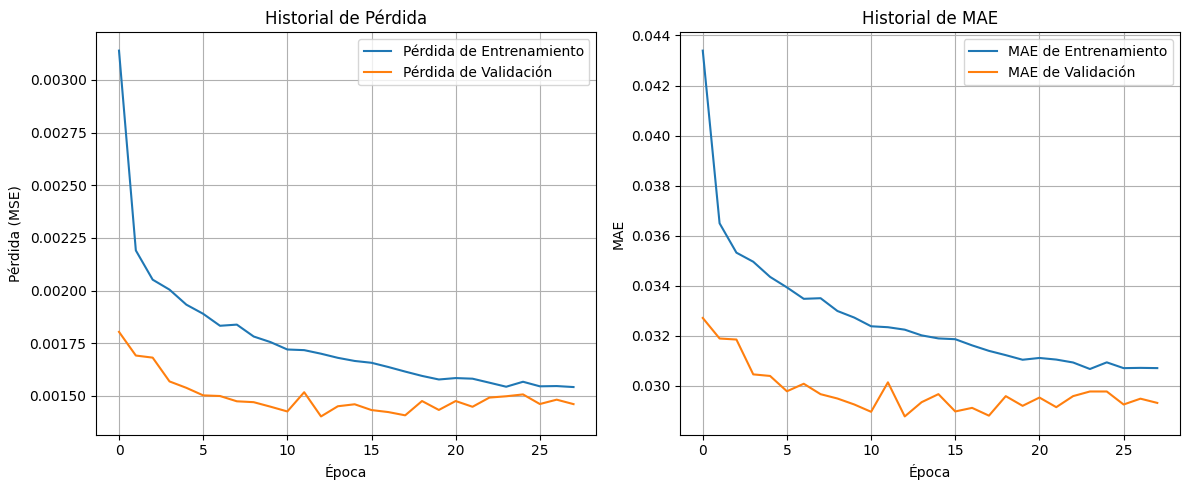


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 9.41°C, Real: 6.80°C
Predicción: 8.78°C, Real: 5.80°C
Predicción: 8.83°C, Real: 9.10°C
Predicción: 10.20°C, Real: 9.40°C
Predicción: 10.36°C, Real: 6.90°C
Predicción: 9.26°C, Real: 6.20°C
Predicción: 8.65°C, Real: 9.80°C
Predicción: 10.15°C, Real: 6.40°C
Predicción: 9.09°C, Real: 9.00°C
Predicción: 10.37°C, Real: 8.40°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0021
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0356
895/895 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.72°C
Coeficiente de Determinación (R-squared) (completo): 0.8356

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


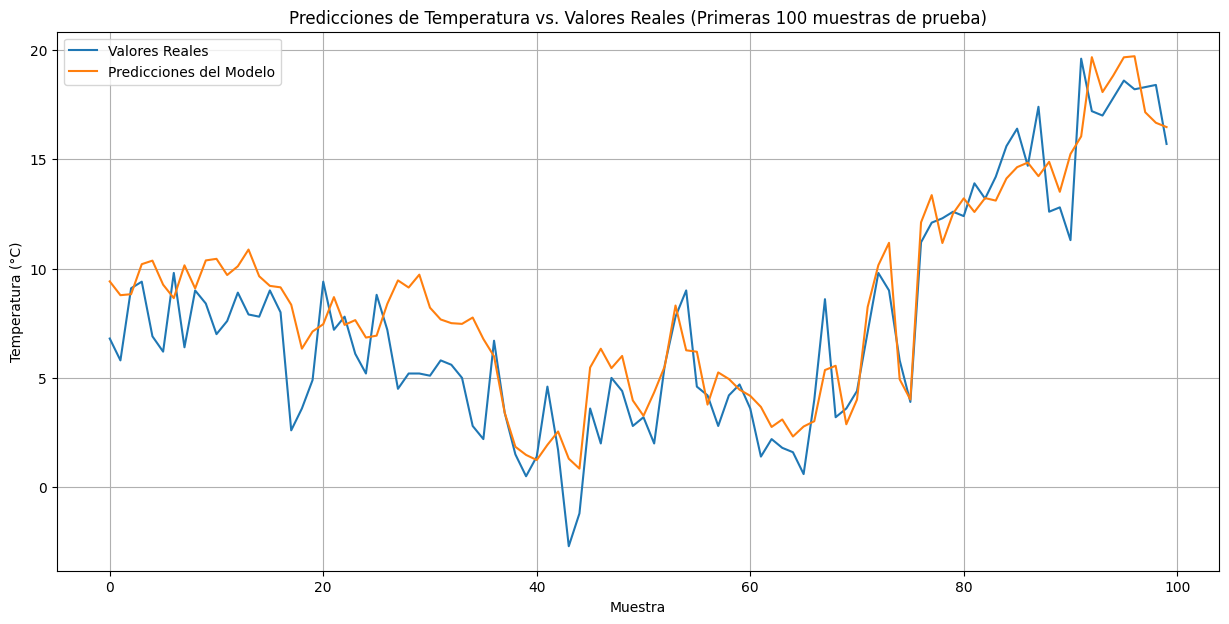


--- Gráfico de Pérdida MSE (Completo) ---


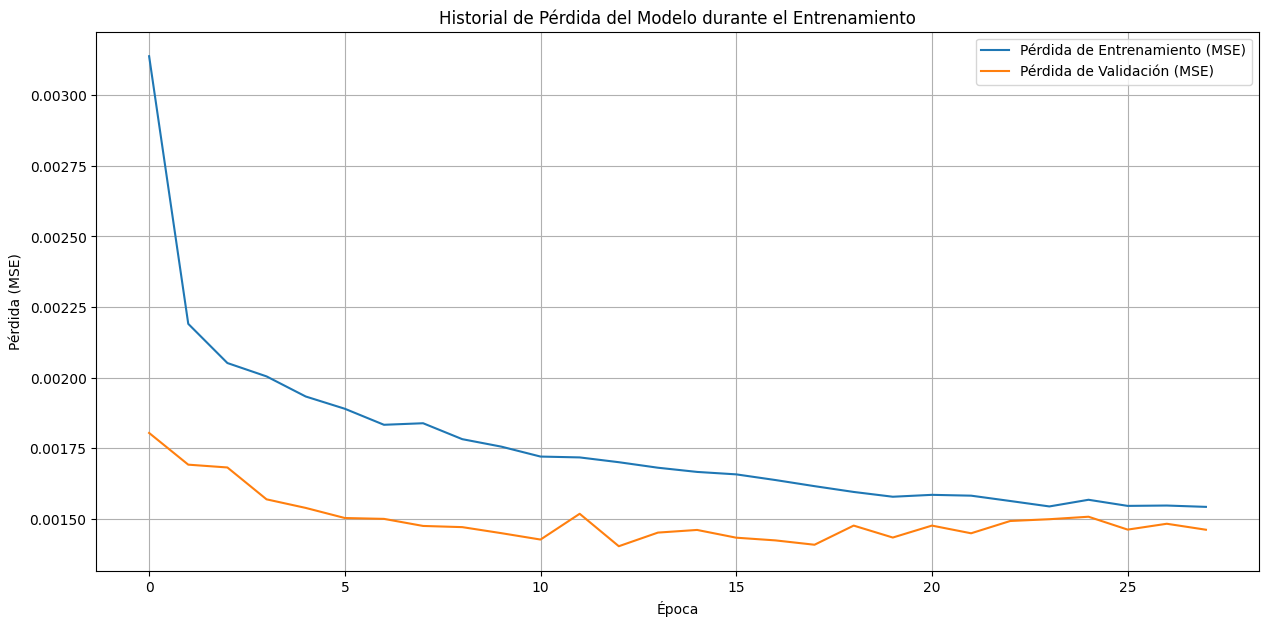


--- Gráfico MAE (Completo) ---


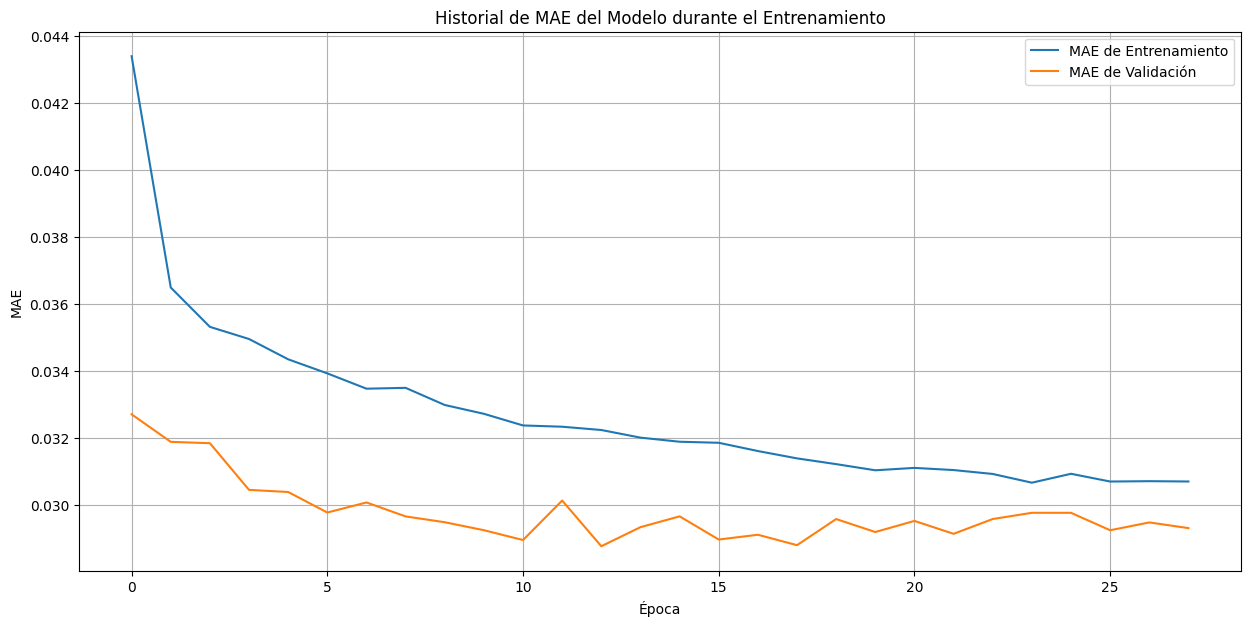


--- Guardando el modelo en: /content/drive/MyDrive/json/2018-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [6]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2018.csv')
print(" Cargando Modelo de 2017 para Fine-tuning con datos de 2018 ")
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2017-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero (¡Esto no es fine-tuning!).")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación ")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs ")
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("\n¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" Cargando LabelEncoder Global y Scalers Base para Fine-tuning ")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base ")
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creando Secuencias Temporales (Todas las Estaciones con IDs) ")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32) ")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba ")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning ")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning) ")
model.summary()
print(" Configurando Callbacks para el Entrenamiento ")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017 ")
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ")
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print(" FIN DEPURACIÓN ")
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print(" FIN DEPURACIÓN DE NAN/INF ")
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba ")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento ")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo ")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba ")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2018-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path} ")
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

df_total cargado desde CSV con 286301 filas y 25 columnas.

--- Cargando Modelo de 2018 para Fine-tuning con datos de 2019 ---
Modelo '2018-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 286301 filas y 25 columnas.
df_total ya cargado con 286301 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286301 entries, 0 to 286300
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       286301 non-null  object 
 1   indicativo  286301 non-null  object 
 2   nombre      286301 non-null  object 
 3   provincia   286301 non-null  object 
 4   altitud     286301 non-null  int64  
 5   tmed        281155 non-null  object 
 6   prec        278882 non-null  object 
 7   tmin        281240 non-null  object 
 8   tmax        281280 non-null  object 
 9   hrMax       273528 non-null  float64
 10  horaHrMax   273405 non-null  object 
 11  hrMin       273545 non-nu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 165356 muestras
Tamaño del conjunto de validación para `fit`: 18373 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (165356, 50, 5)
Shape de X_train_set_station_ids: (165356, 50)
Shape de y_train_set: (165356, 1)
Shape de X_val_set_numeric: (18373, 50, 5)
Shape de X_val_set_station_ids: (18373, 50)
Shape de y_val_set: (18373, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - loss: 0.0037 - mae: 0.0481 - val_loss: 0.0019 - val_mae: 0.0347 - learning_rate: 1.0000e-04

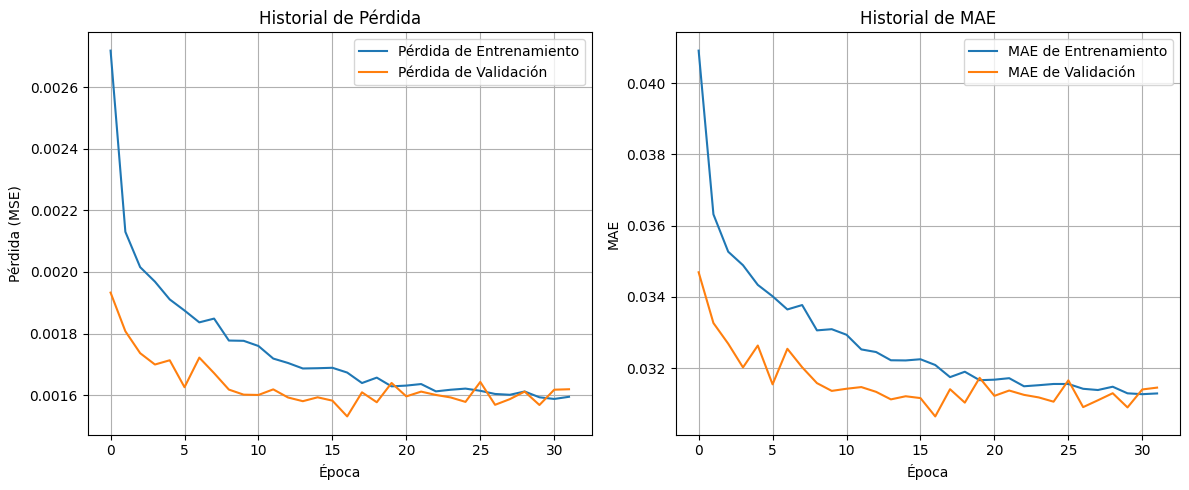


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 17.41°C, Real: 18.40°C
Predicción: 20.03°C, Real: 17.00°C
Predicción: 16.41°C, Real: 14.40°C
Predicción: 14.83°C, Real: 13.20°C
Predicción: 16.70°C, Real: 15.90°C
Predicción: 18.35°C, Real: 15.60°C
Predicción: 17.12°C, Real: 15.70°C
Predicción: 17.57°C, Real: 16.40°C
Predicción: 18.36°C, Real: 14.80°C
Predicción: 17.52°C, Real: 16.00°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0016
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0297
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.43°C
Coeficiente de Determinación (R-squared) (completo): 0.8692

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


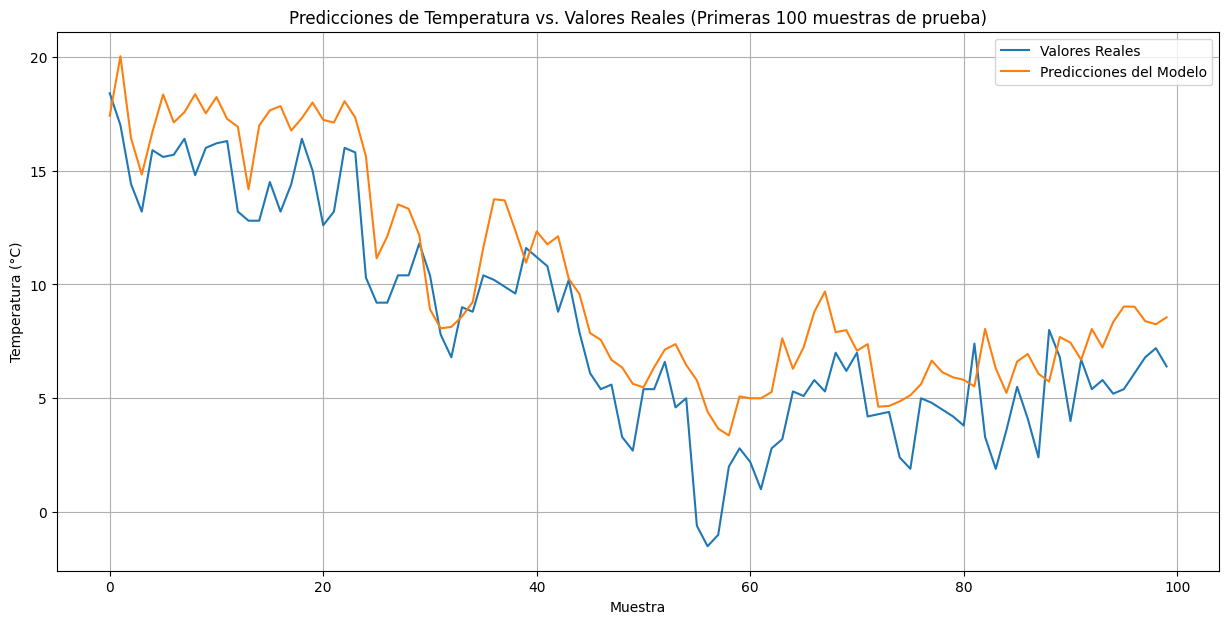


--- Gráfico de Pérdida MSE (Completo) ---


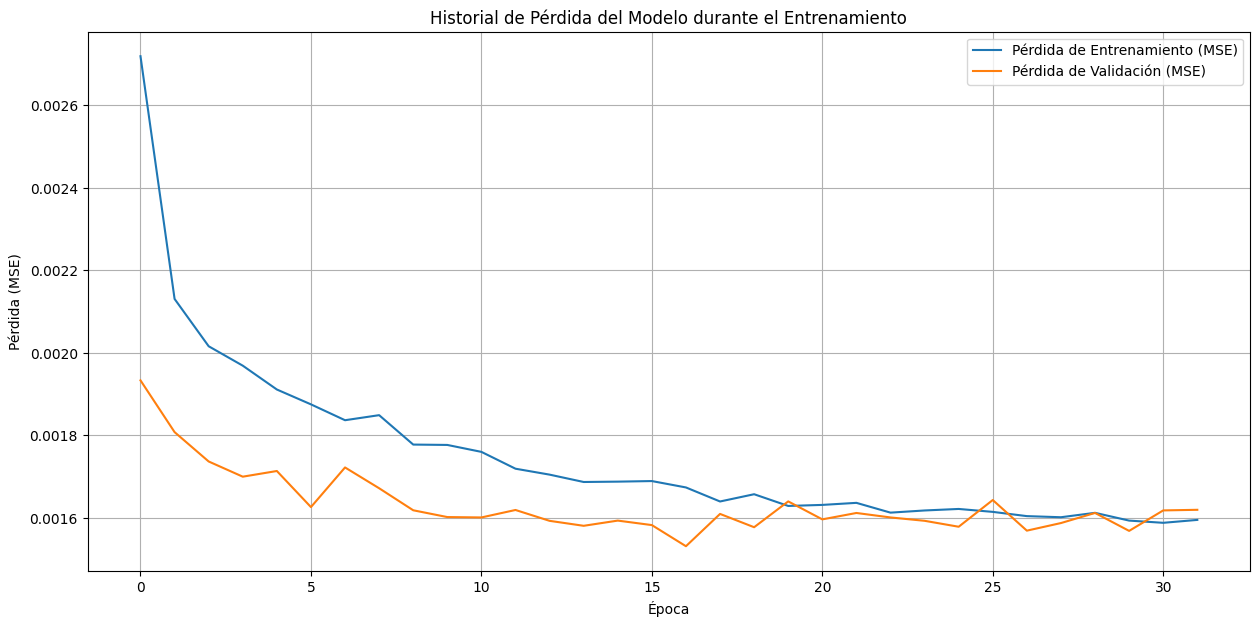


--- Gráfico MAE (Completo) ---


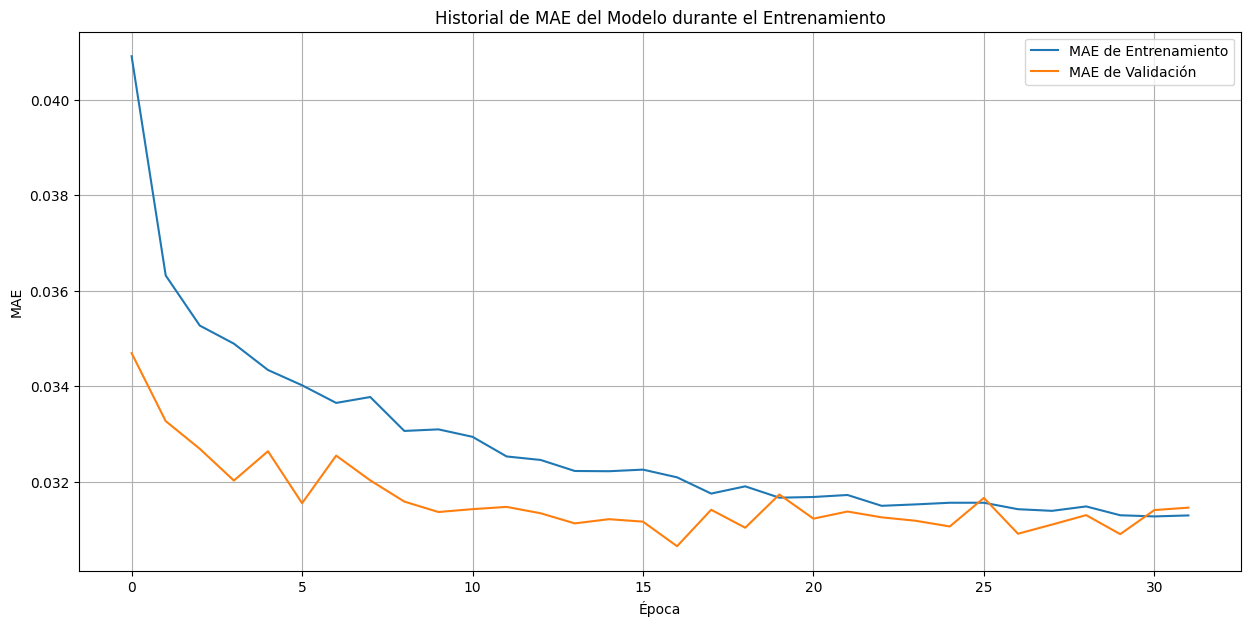


--- Guardando el modelo en: /content/drive/MyDrive/json/2019-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [7]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2019.csv')
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
print(" Cargando Modelo de 2018 para Fine-tuning con datos de 2019 ")
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2018-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero (¡Esto no es fine-tuning!).")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación ")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs ")
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("\n¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" Cargando LabelEncoder Global y Scalers Base para Fine-tuning ")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base ")
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creando Secuencias Temporales (Todas las Estaciones con IDs) ")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32) ")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba ")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning ")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning) ")
model.summary()
print(" Configurando Callbacks para el Entrenamiento ")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017 ")
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ")
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print(" FIN DEPURACIÓN ")
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print(" FIN DEPURACIÓN DE NAN/INF ")
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba ")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento ")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo ")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba ")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2019-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path} ")
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

df_total cargado desde CSV con 312958 filas y 25 columnas.

--- Cargando Modelo de 2019 para Fine-tuning con datos de 2020 ---
Modelo '2019-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 312958 filas y 25 columnas.
df_total ya cargado con 312958 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312958 entries, 0 to 312957
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       312958 non-null  object 
 1   indicativo  312958 non-null  object 
 2   nombre      312958 non-null  object 
 3   provincia   312958 non-null  object 
 4   altitud     312958 non-null  int64  
 5   tmed        307074 non-null  object 
 6   prec        303912 non-null  object 
 7   tmin        307167 non-null  object 
 8   tmax        307219 non-null  object 
 9   hrMax       298209 non-null  float64
 10  horaHrMax   298102 non-null  object 
 11  hrMin       298203 non-nu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 182601 muestras
Tamaño del conjunto de validación para `fit`: 20289 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (182601, 50, 5)
Shape de X_train_set_station_ids: (182601, 50)
Shape de y_train_set: (182601, 1)
Shape de X_val_set_numeric: (20289, 50, 5)
Shape de X_val_set_station_ids: (20289, 50)
Shape de y_val_set: (20289, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
2854/2854 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - loss: 0.0024 - mae: 0.0383 - val_loss: 0.0017 - val_mae: 0.0320 - learning_rate: 1.0000e-04

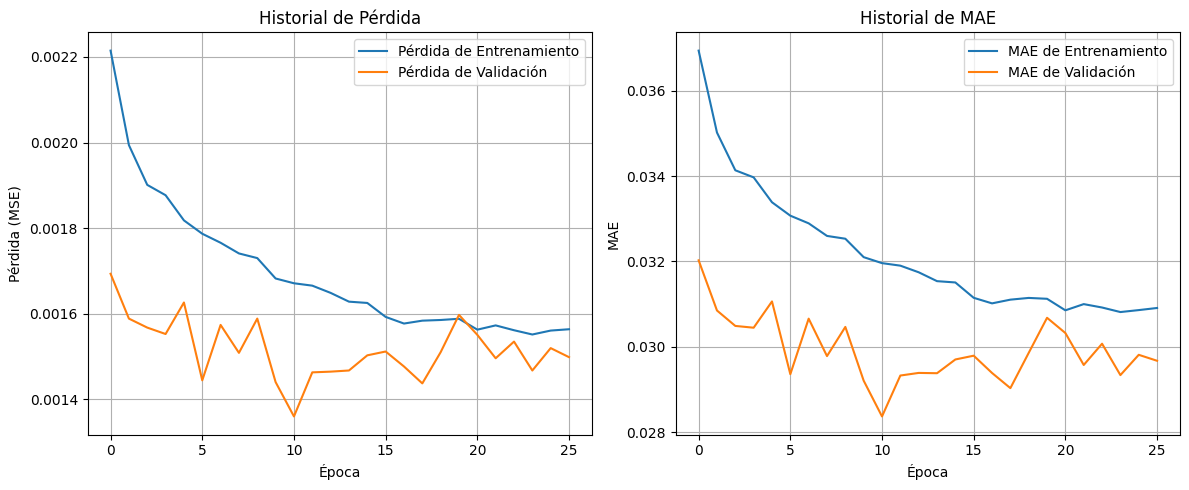


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 10.53°C, Real: 6.40°C
Predicción: 9.12°C, Real: 5.80°C
Predicción: 9.01°C, Real: 5.60°C
Predicción: 9.41°C, Real: 5.40°C
Predicción: 9.00°C, Real: 6.00°C
Predicción: 9.08°C, Real: 5.20°C
Predicción: 9.02°C, Real: -0.00°C
Predicción: 7.22°C, Real: 5.00°C
Predicción: 9.51°C, Real: 6.20°C
Predicción: 8.00°C, Real: 6.20°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0016
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0289
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.40°C
Coeficiente de Determinación (R-squared) (completo): 0.8822

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


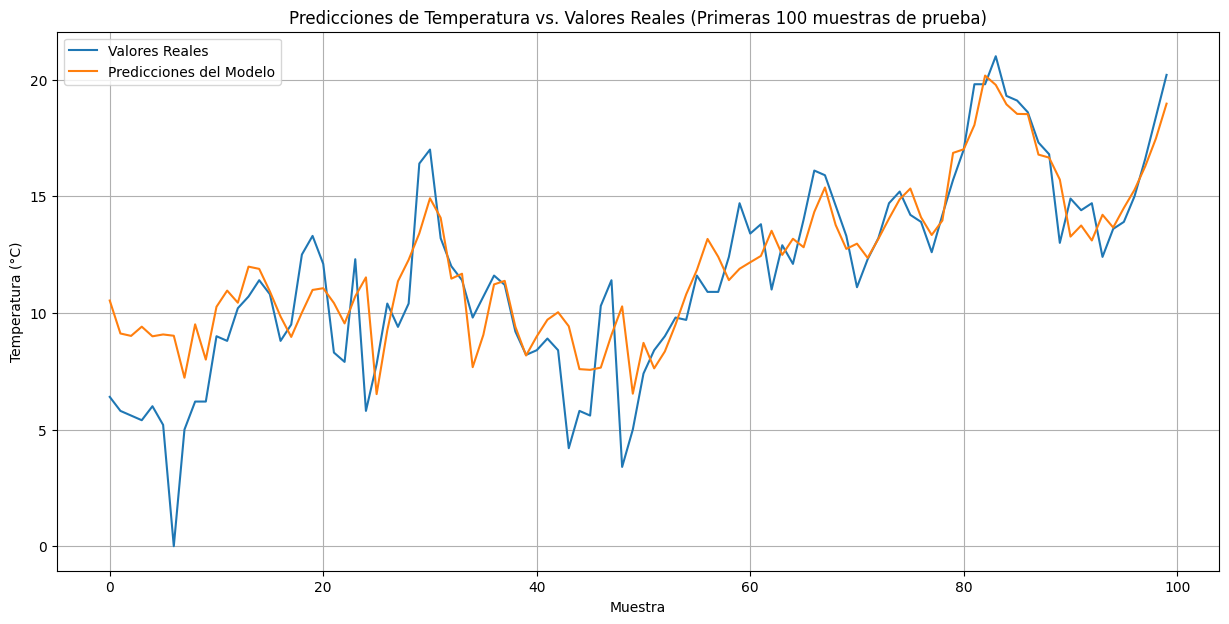


--- Gráfico de Pérdida MSE (Completo) ---


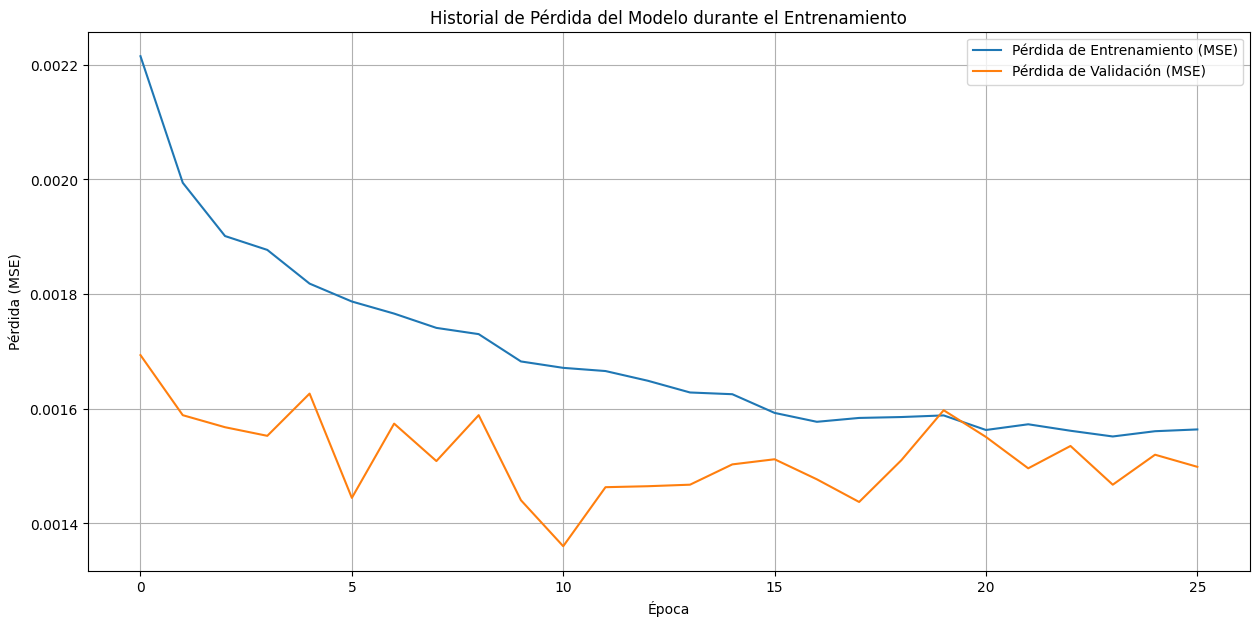


--- Gráfico MAE (Completo) ---


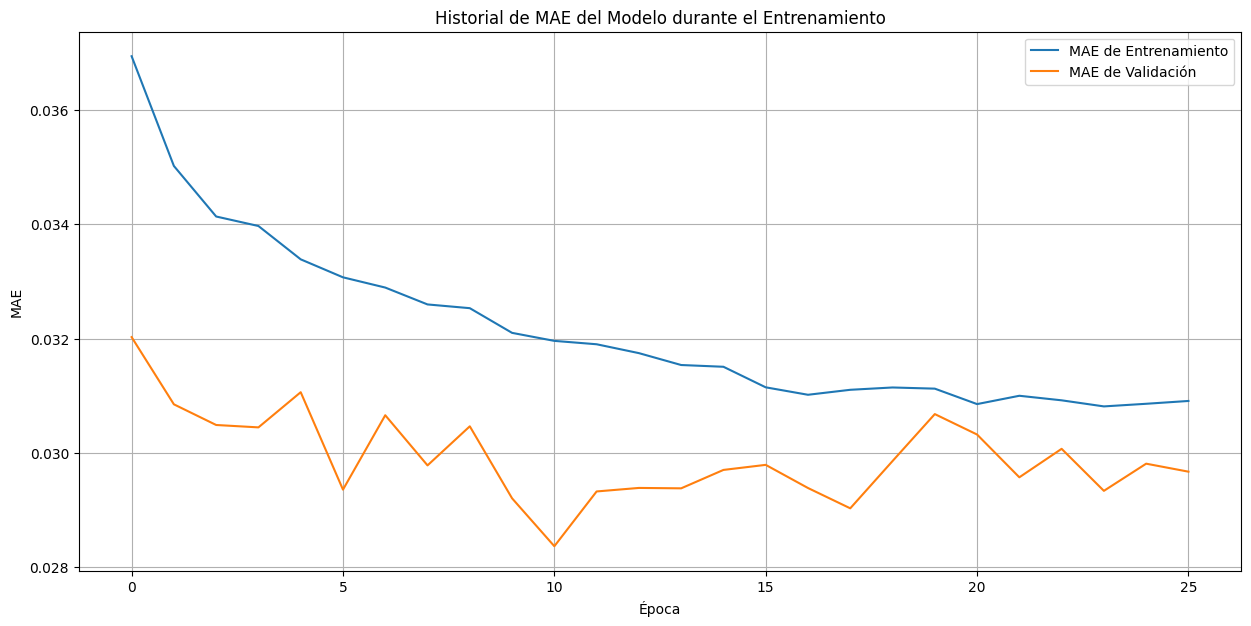


--- Guardando el modelo en: /content/drive/MyDrive/json/2020-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [8]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2020.csv')
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
print(" Cargando Modelo de 2019 para Fine-tuning con datos de 2020")
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2019-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero (¡Esto no es fine-tuning!).")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs")
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("\n¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" Cargando LabelEncoder Global y Scalers Base para Fine-tuning")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base")
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creando Secuencias Temporales (Todas las Estaciones con IDs)")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32)")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning)")
model.summary()
print(" Configurando Callbacks para el Entrenamiento")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017")
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit")
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print("--- FIN DEPURACIÓN")
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print("--- FIN DEPURACIÓN DE NAN/INF")
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo)")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo)")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo)")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2020-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path}")
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

df_total cargado desde CSV con 303760 filas y 25 columnas.

--- Cargando Modelo de 2020 para Fine-tuning con datos de 2021 ---
Modelo '2020-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 303760 filas y 25 columnas.
df_total ya cargado con 303760 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303760 entries, 0 to 303759
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       303760 non-null  object 
 1   indicativo  303760 non-null  object 
 2   nombre      303760 non-null  object 
 3   provincia   303760 non-null  object 
 4   altitud     303760 non-null  int64  
 5   tmed        298023 non-null  object 
 6   prec        295698 non-null  object 
 7   tmin        298115 non-null  object 
 8   tmax        298186 non-null  object 
 9   hrMax       289163 non-null  float64
 10  horaHrMax   289082 non-null  object 
 11  hrMin       289181 non-nu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 176674 muestras
Tamaño del conjunto de validación para `fit`: 19631 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (176674, 50, 5)
Shape de X_train_set_station_ids: (176674, 50)
Shape de y_train_set: (176674, 1)
Shape de X_val_set_numeric: (19631, 50, 5)
Shape de X_val_set_station_ids: (19631, 50)
Shape de y_val_set: (19631, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
2761/2761 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - loss: 0.0022 - mae: 0.0369 - val_loss: 0.0019 - val_mae: 0.0337 - learning_rate: 1.0000e-04

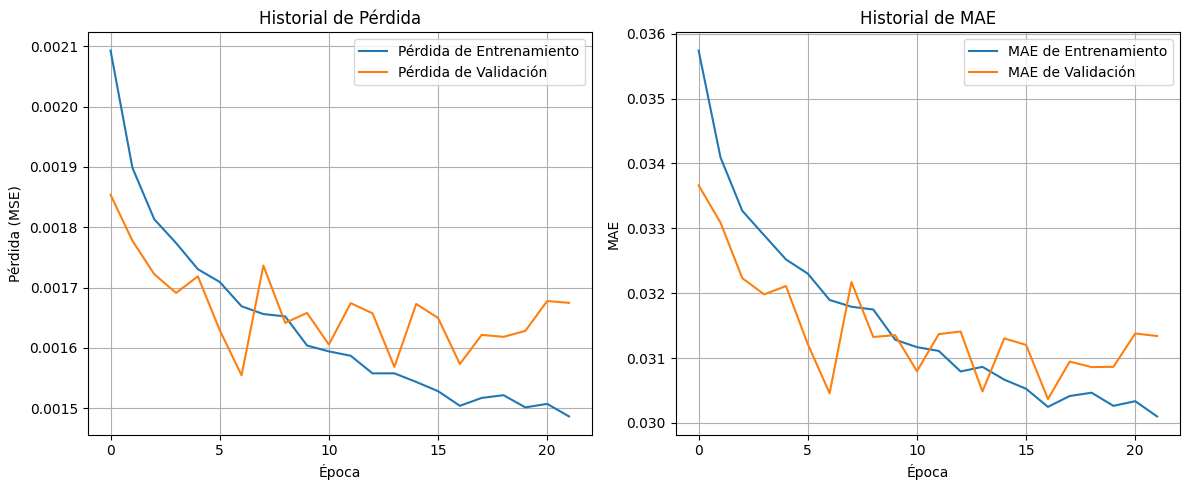


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 20.29°C, Real: 20.60°C
Predicción: 21.43°C, Real: 22.80°C
Predicción: 22.96°C, Real: 23.60°C
Predicción: 23.54°C, Real: 24.20°C
Predicción: 23.67°C, Real: 26.20°C
Predicción: 24.24°C, Real: 25.00°C
Predicción: 22.89°C, Real: 25.30°C
Predicción: 23.46°C, Real: 23.70°C
Predicción: 22.15°C, Real: 22.60°C
Predicción: 22.55°C, Real: 22.80°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0016
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0284
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.37°C
Coeficiente de Determinación (R-squared) (completo): 0.8851

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


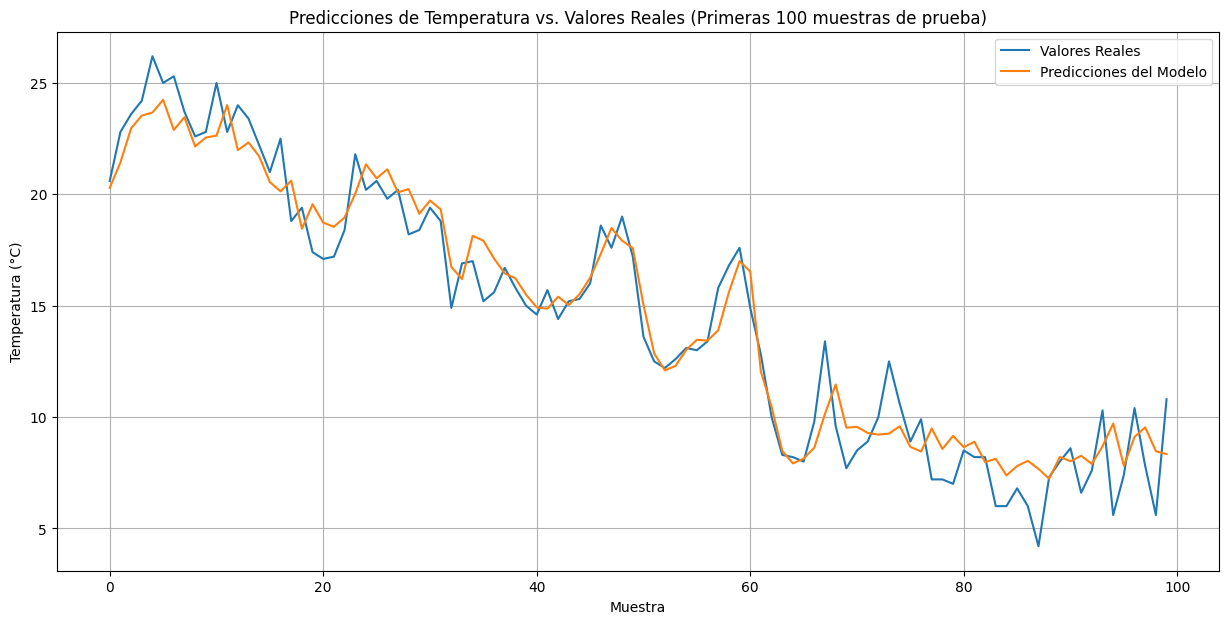


--- Gráfico de Pérdida MSE (Completo) ---


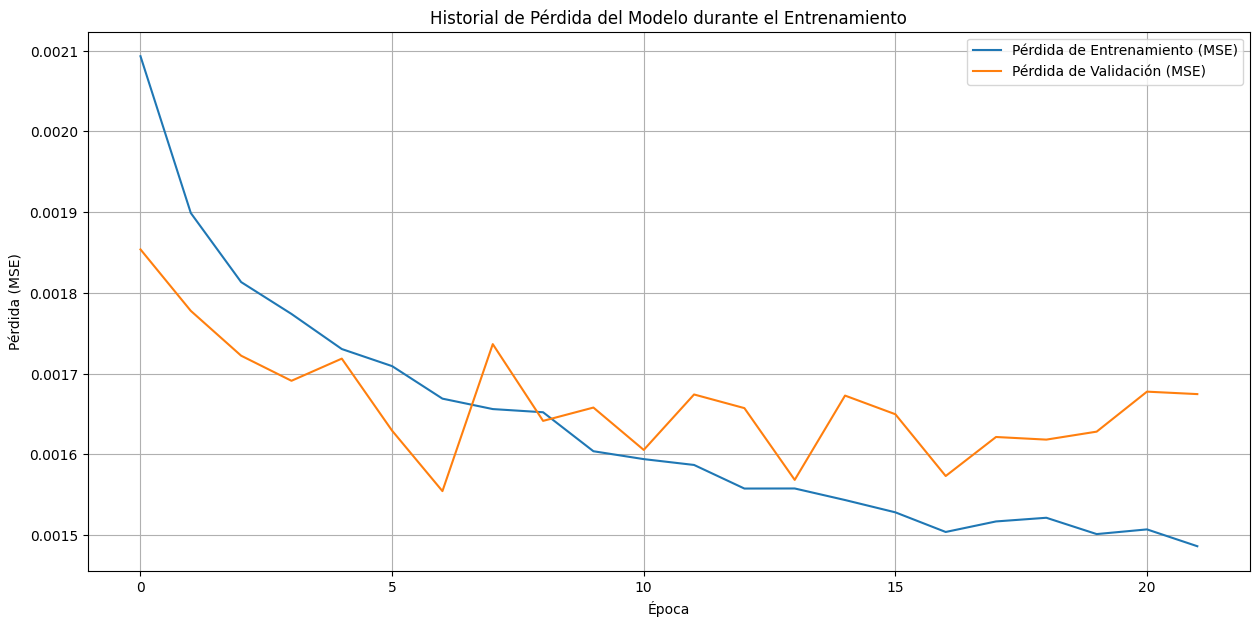


--- Gráfico MAE (Completo) ---


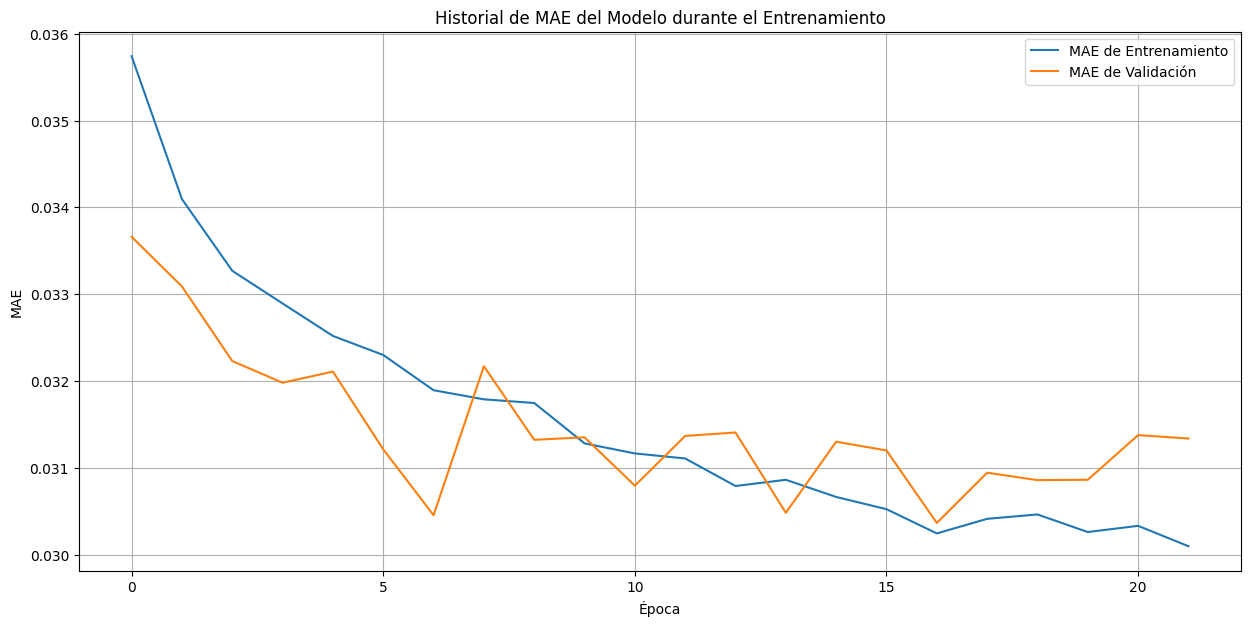


--- Guardando el modelo en: /content/drive/MyDrive/json/2021-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [9]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2021.csv')
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
print(" Cargando Modelo de 2020 para Fine-tuning con datos de 2021" )
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2020-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero (¡Esto no es fine-tuning!).")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación" )
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs" )
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("\n¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" Cargando LabelEncoder Global y Scalers Base para Fine-tuning" )
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base" )
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creando Secuencias Temporales (Todas las Estaciones con IDs) ")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32)" )
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba" )
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning" )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning)" )
model.summary()
print(" Configurando Callbacks para el Entrenamiento" )
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017" )
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit" )
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print("--- FIN DEPURACIÓN" )
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print("--- FIN DEPURACIÓN DE NAN/INF" )
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba" )
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento" )
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo" )
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba" )
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo)" )
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo)" )
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo)" )
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2021-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path}" )
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

df_total cargado desde CSV con 304806 filas y 25 columnas.

--- Cargando Modelo de 2021 para Fine-tuning con datos de 2022 ---
Modelo '2021-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 304806 filas y 25 columnas.
df_total ya cargado con 304806 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304806 entries, 0 to 304805
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       304806 non-null  object 
 1   indicativo  304806 non-null  object 
 2   nombre      304806 non-null  object 
 3   provincia   304806 non-null  object 
 4   altitud     304806 non-null  int64  
 5   tmed        299429 non-null  object 
 6   prec        297724 non-null  object 
 7   tmin        299510 non-null  object 
 8   tmax        299550 non-null  object 
 9   hrMax       291256 non-null  float64
 10  horaHrMax   291187 non-null  object 
 11  hrMin       291275 non-nu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 178146 muestras
Tamaño del conjunto de validación para `fit`: 19795 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (178146, 50, 5)
Shape de X_train_set_station_ids: (178146, 50)
Shape de y_train_set: (178146, 1)
Shape de X_val_set_numeric: (19795, 50, 5)
Shape de X_val_set_station_ids: (19795, 50)
Shape de y_val_set: (19795, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - loss: 0.0023 - mae: 0.0381 - val_loss: 0.0016 - val_mae: 0.0307 - learning_rate: 1.0000e-04

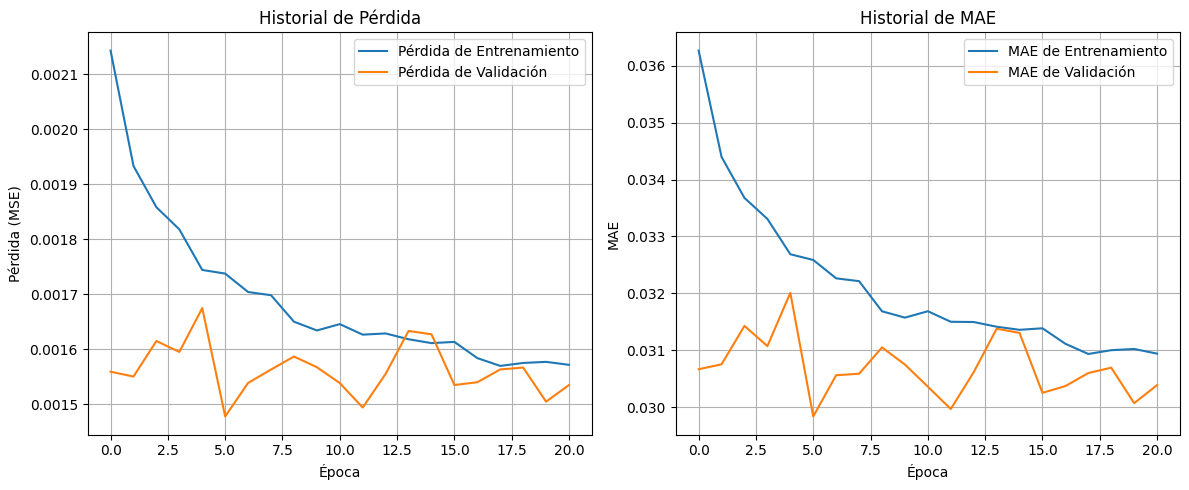


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 21.33°C, Real: 21.40°C
Predicción: 21.35°C, Real: 20.60°C
Predicción: 21.04°C, Real: 20.70°C
Predicción: 20.14°C, Real: 18.20°C
Predicción: 18.04°C, Real: 19.00°C
Predicción: 19.14°C, Real: 19.00°C
Predicción: 19.44°C, Real: 21.00°C
Predicción: 20.39°C, Real: 19.40°C
Predicción: 19.98°C, Real: 20.00°C
Predicción: 20.50°C, Real: 21.00°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0015
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0281
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.36°C
Coeficiente de Determinación (R-squared) (completo): 0.8906

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


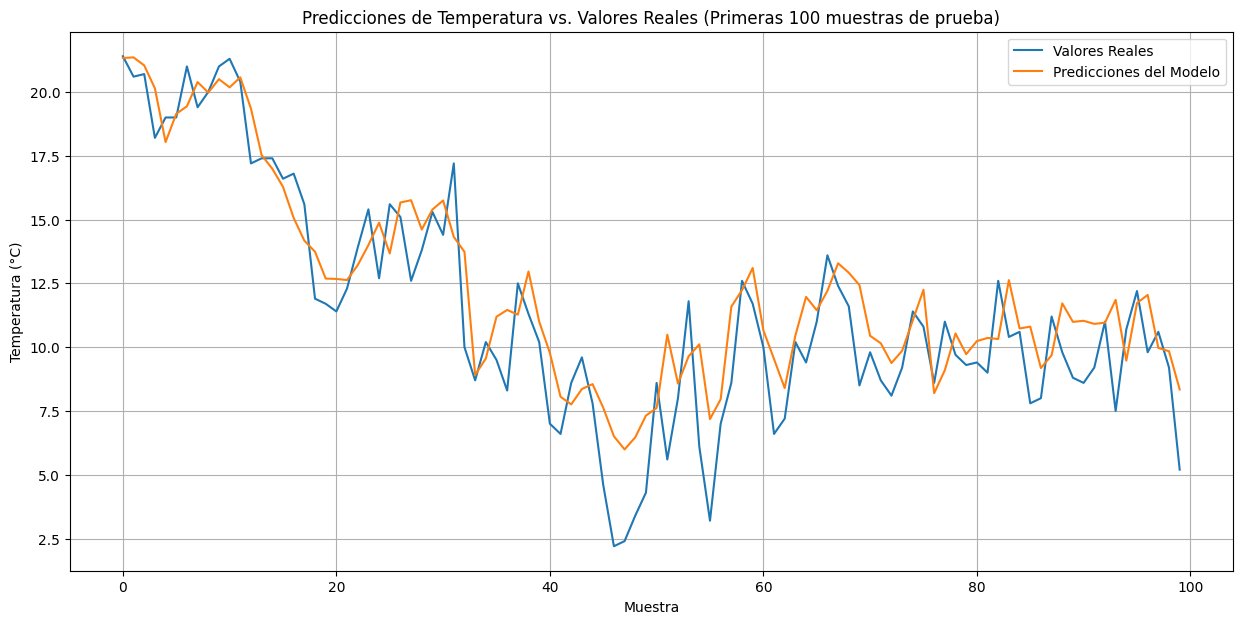


--- Gráfico de Pérdida MSE (Completo) ---


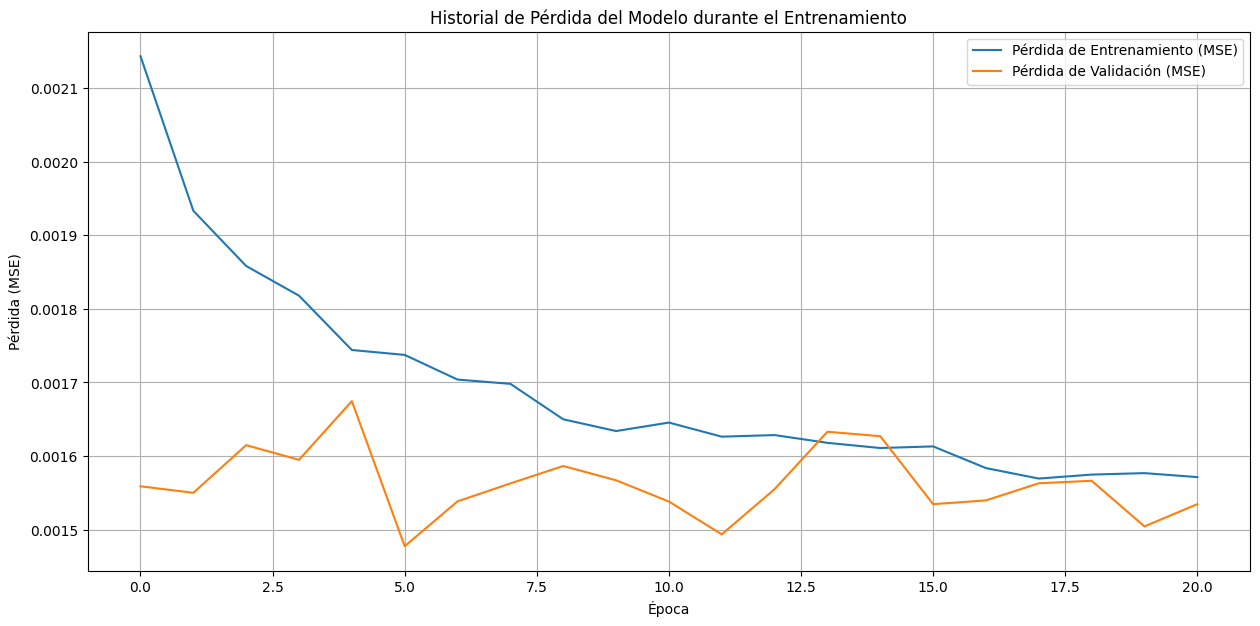


--- Gráfico MAE (Completo) ---


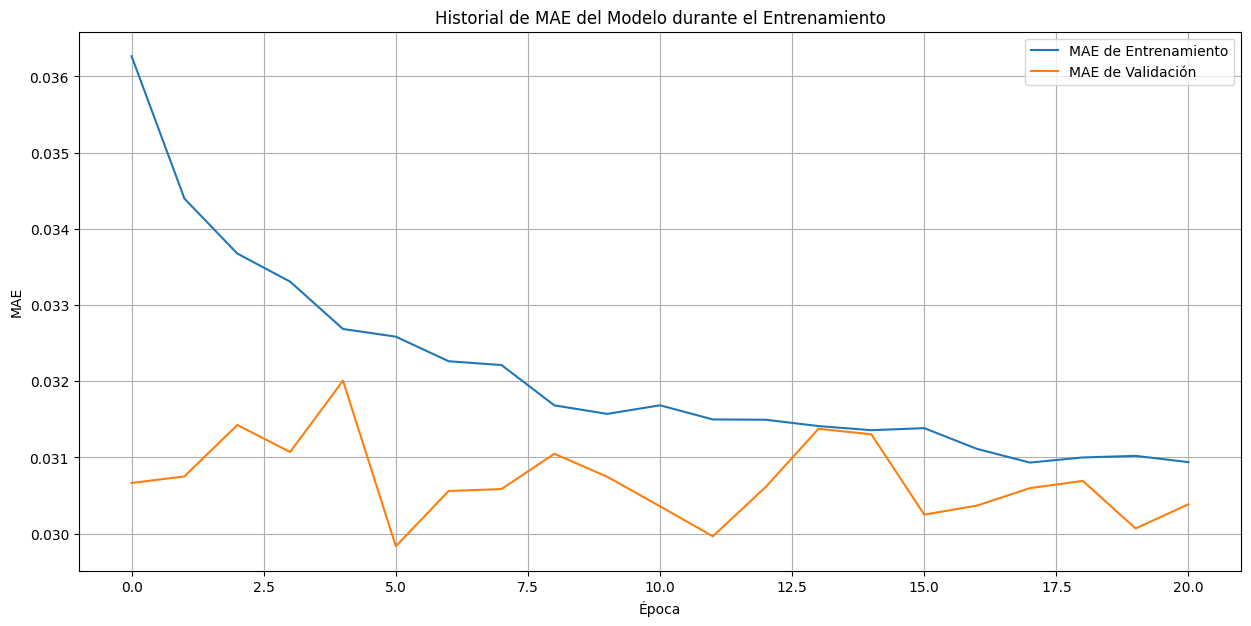


--- Guardando el modelo en: /content/drive/MyDrive/json/2022-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [10]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2022.csv')
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
print(" Cargando Modelo de 2021 para Fine-tuning con datos de 2022 ")
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2021-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero (¡Esto no es fine-tuning!).")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación ")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs ")
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("\n¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" Cargando LabelEncoder Global y Scalers Base para Fine-tuning ")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base ")
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creando Secuencias Temporales (Todas las Estaciones con IDs) ")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32) ")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba ")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning ")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning) ")
model.summary()
print(" Configurando Callbacks para el Entrenamiento ")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017 ")
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ")
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print(" FIN DEPURACIÓN ")
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print("--- FIN DEPURACIÓN DE NAN/INF ---")
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba ---")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo ---")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba ---")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo) ---")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo) ---")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo) ---")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2022-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path} ---")
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

df_total cargado desde CSV con 281195 filas y 25 columnas.

--- Cargando Modelo de 2022 para Fine-tuning con datos de 2023 ---
Modelo '2022-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 281195 filas y 25 columnas.
df_total ya cargado con 281195 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281195 entries, 0 to 281194
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       281195 non-null  object 
 1   indicativo  281195 non-null  object 
 2   nombre      281195 non-null  object 
 3   provincia   281195 non-null  object 
 4   altitud     281195 non-null  int64  
 5   tmed        275231 non-null  object 
 6   prec        273794 non-null  object 
 7   tmin        275307 non-null  object 
 8   tmax        275336 non-null  object 
 9   hrMax       269581 non-null  float64
 10  horaHrMax   269541 non-null  object 
 11  hrMin       269594 non-nu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 160721 muestras
Tamaño del conjunto de validación para `fit`: 17858 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (160721, 50, 5)
Shape de X_train_set_station_ids: (160721, 50)
Shape de y_train_set: (160721, 1)
Shape de X_val_set_numeric: (17858, 50, 5)
Shape de X_val_set_station_ids: (17858, 50)
Shape de y_val_set: (17858, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
2512/2512 ━━━━━━━━━━━━━━━━━━━━ 57s 20ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 0.0017 - val_mae: 0.0317 - learning_rate: 1.0000e-04

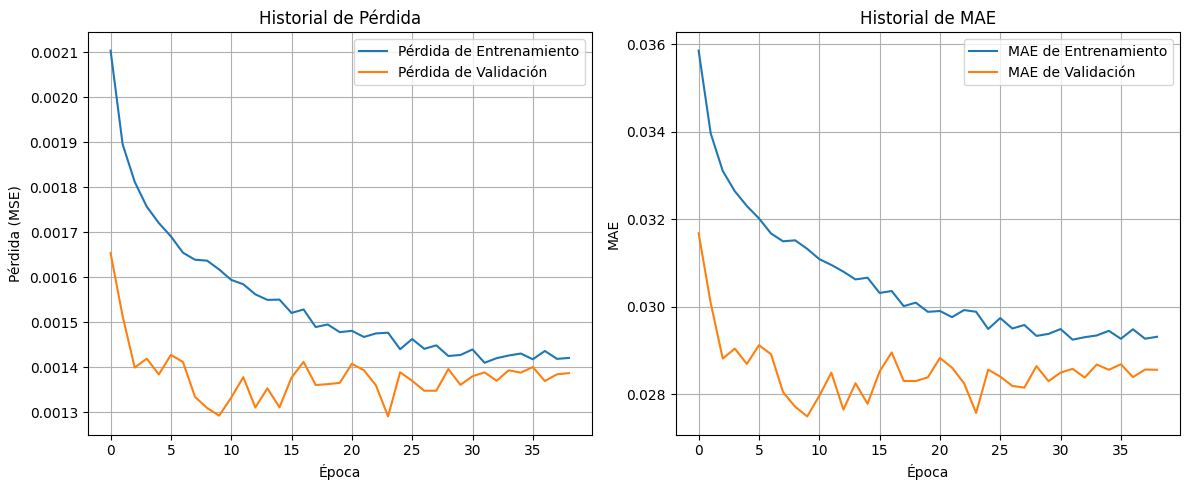


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 22.12°C, Real: 21.60°C
Predicción: 21.96°C, Real: 22.10°C
Predicción: 23.85°C, Real: 25.60°C
Predicción: 26.28°C, Real: 28.20°C
Predicción: 26.90°C, Real: 26.90°C
Predicción: 25.52°C, Real: 31.20°C
Predicción: 26.78°C, Real: 26.70°C
Predicción: 24.25°C, Real: 25.60°C
Predicción: 24.82°C, Real: 24.80°C
Predicción: 23.50°C, Real: 26.90°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0017
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0304
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.47°C
Coeficiente de Determinación (R-squared) (completo): 0.8709

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


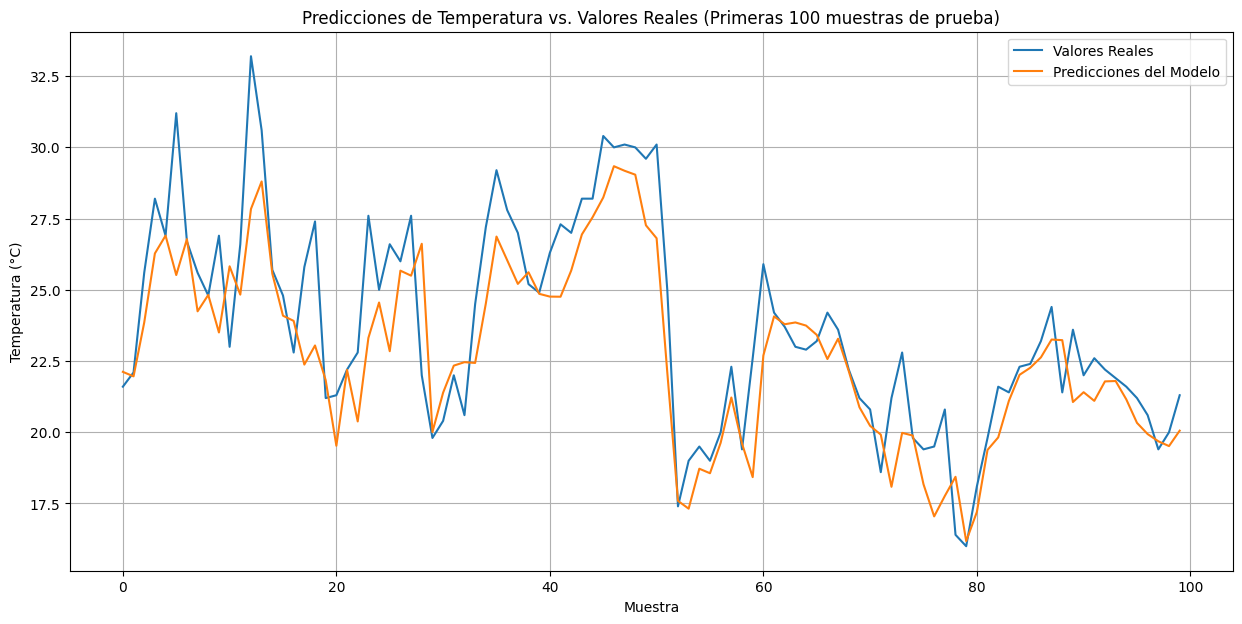


--- Gráfico de Pérdida MSE (Completo) ---


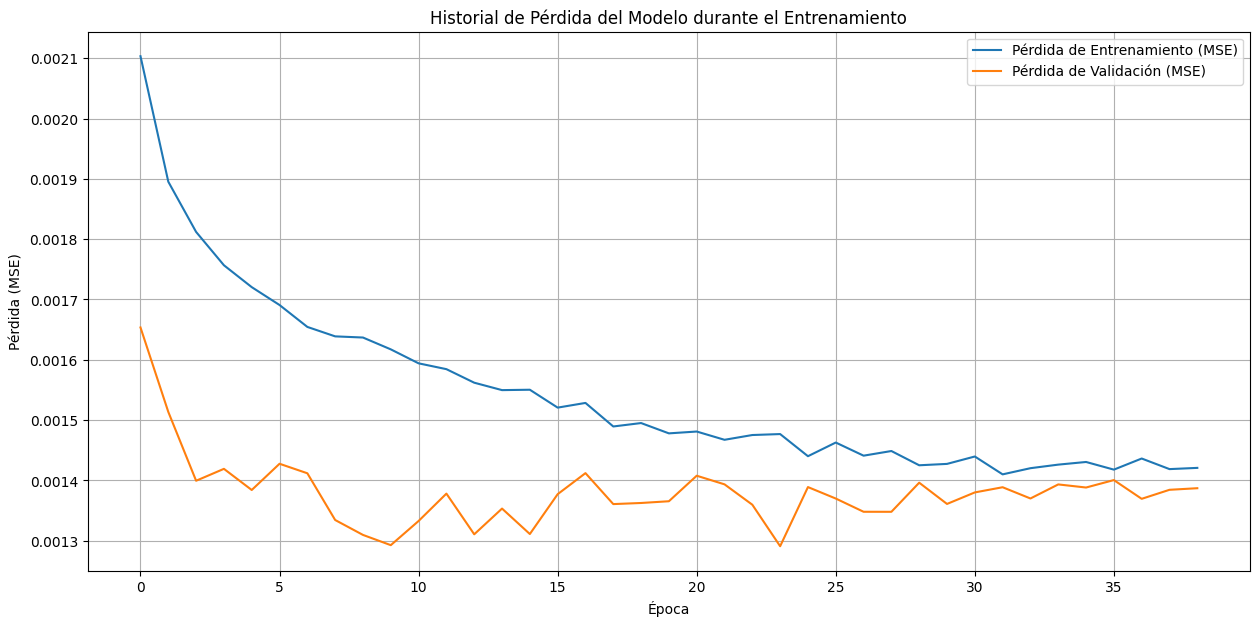


--- Gráfico MAE (Completo) ---


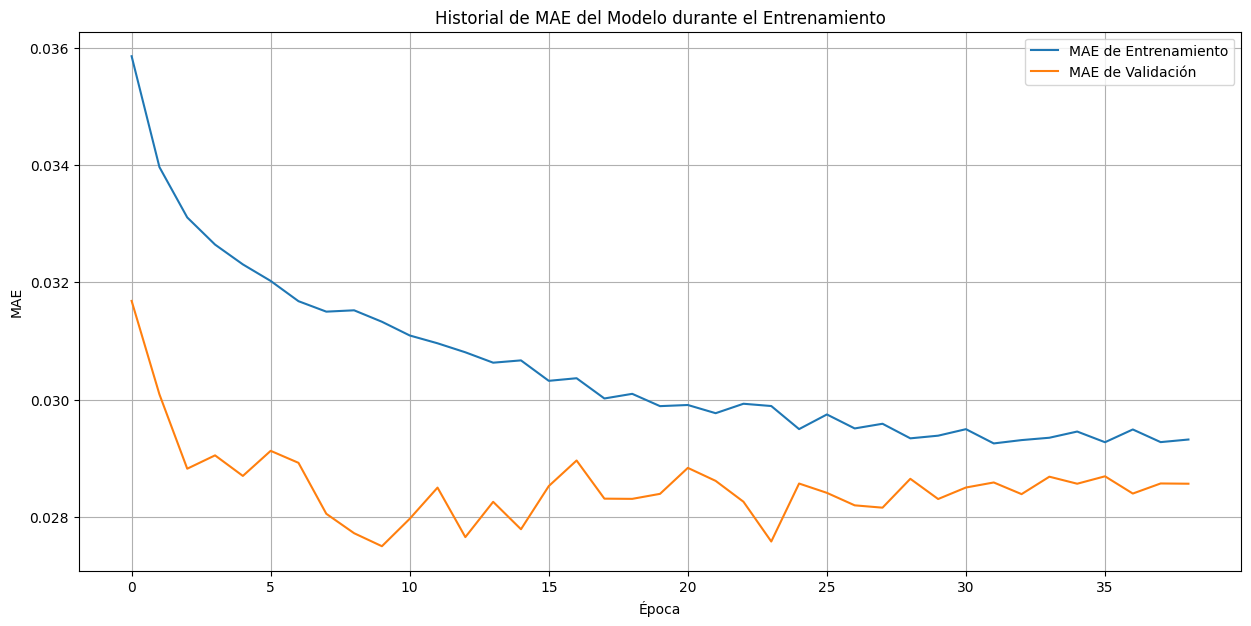


--- Guardando el modelo en: /content/drive/MyDrive/json/2023-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [11]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2023.csv')
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
print(" Cargando Modelo de 2022 para Fine-tuning con datos de 2023 ")
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2022-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero (¡Esto no es fine-tuning!).")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación ")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs ")
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("\n¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" Cargando LabelEncoder Global y Scalers Base para Fine-tuning ")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base ")
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creando Secuencias Multivariadas (Corregida) ")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32) ")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba ")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning ")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning) ")
model.summary()
print(" Configurando Callbacks para el Entrenamiento ")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017 ")
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ")
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print(" FIN DEPURACIÓN ")
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print(" FIN DEPURACIÓN DE NAN/INF ")
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba ---")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo ---")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba ---")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo) ---")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo) ---")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo) ---")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2023-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path} ---")
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

df_total cargado desde CSV con 323794 filas y 25 columnas.

--- Cargando Modelo de 2023 para Fine-tuning con datos de 2024 ---
Modelo '2023-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 323794 filas y 25 columnas.
df_total ya cargado con 323794 filas y 14 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323794 entries, 0 to 323793
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       323794 non-null  object 
 1   indicativo  323794 non-null  object 
 2   nombre      323794 non-null  object 
 3   provincia   323794 non-null  object 
 4   altitud     323794 non-null  int64  
 5   tmed        316310 non-null  object 
 6   prec        313160 non-null  object 
 7   tmin        316398 non-null  object 
 8   tmax        316527 non-null  object 
 9   hrMax       310229 non-null  float64
 10  horaHrMax   309922 non-null  object 
 11  hrMin       310292 non-nu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 187843 muestras
Tamaño del conjunto de validación para `fit`: 20872 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (187843, 50, 5)
Shape de X_train_set_station_ids: (187843, 50)
Shape de y_train_set: (187843, 1)
Shape de X_val_set_numeric: (20872, 50, 5)
Shape de X_val_set_station_ids: (20872, 50)
Shape de y_val_set: (20872, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 64s 20ms/step - loss: 0.0025 - mae: 0.0387 - val_loss: 0.0017 - val_mae: 0.0324 - learning_rate: 1.0000e-04

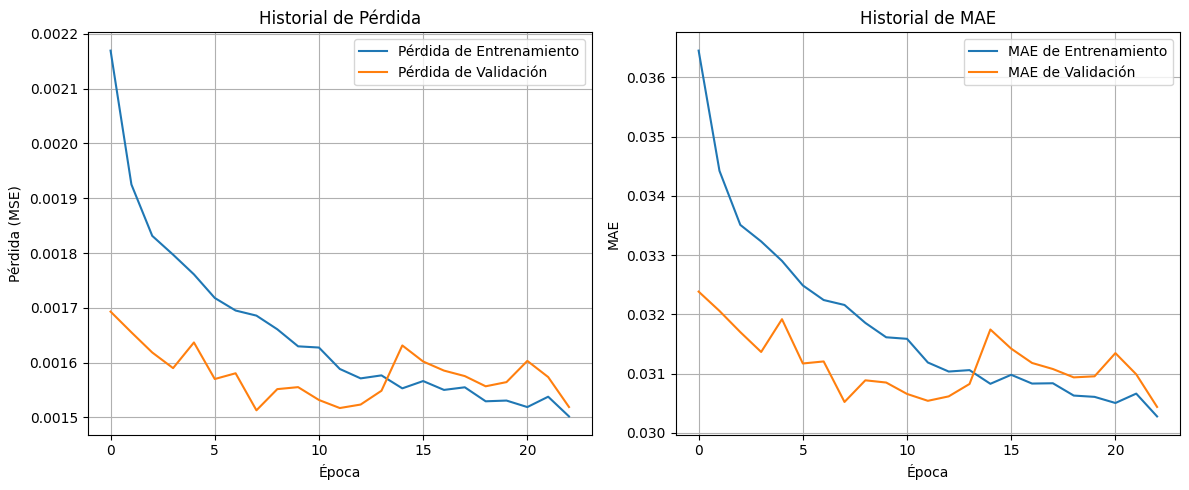


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 19.39°C, Real: 21.20°C
Predicción: 19.03°C, Real: 18.80°C
Predicción: 18.37°C, Real: 19.00°C
Predicción: 16.81°C, Real: 16.80°C
Predicción: 15.84°C, Real: 17.80°C
Predicción: 16.85°C, Real: 15.00°C
Predicción: 15.54°C, Real: 14.60°C
Predicción: 15.95°C, Real: 17.40°C
Predicción: 16.99°C, Real: 18.00°C
Predicción: 16.77°C, Real: 17.90°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0018
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0322
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.56°C
Coeficiente de Determinación (R-squared) (completo): 0.8567

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


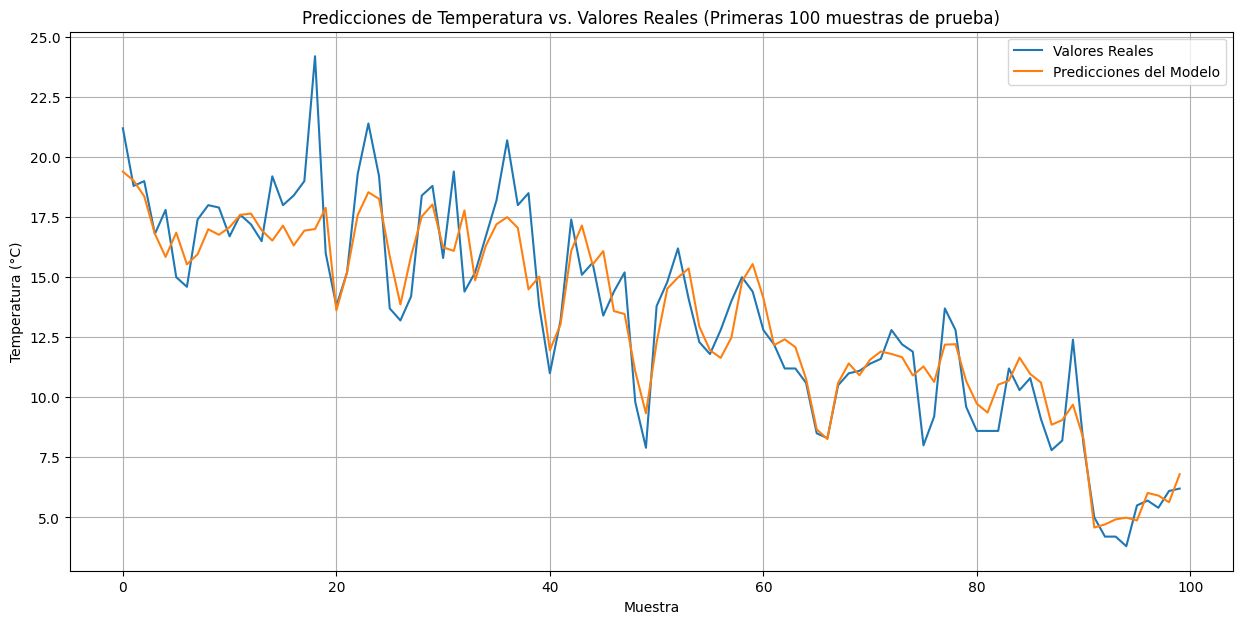


--- Gráfico de Pérdida MSE (Completo) ---


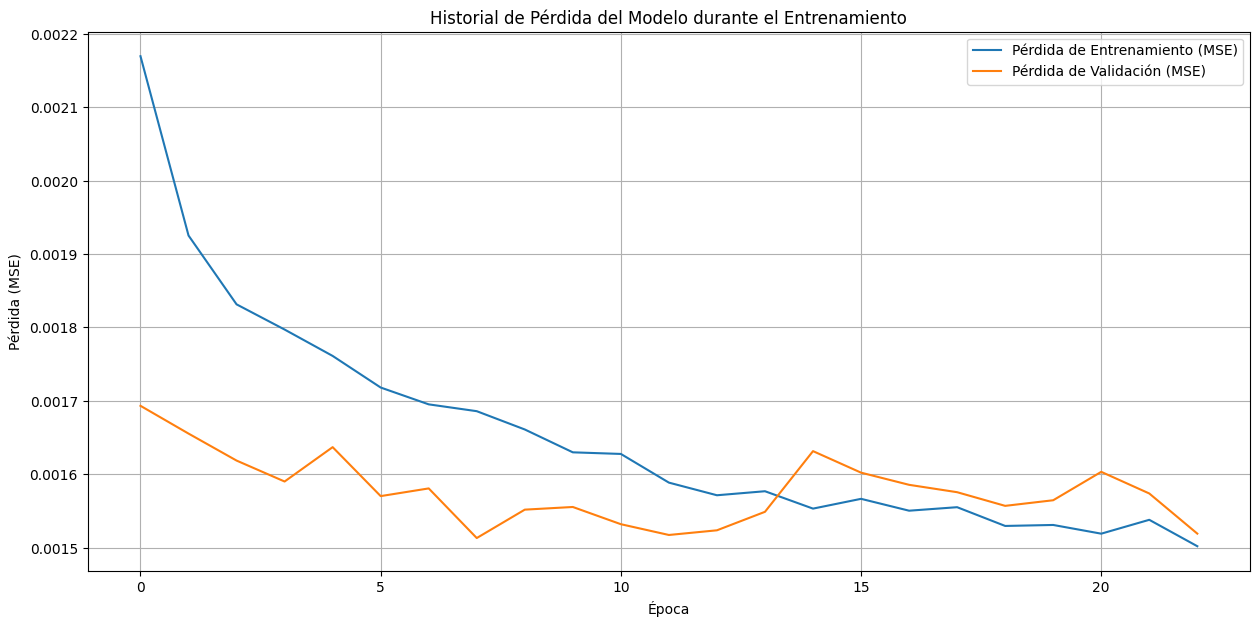


--- Gráfico MAE (Completo) ---


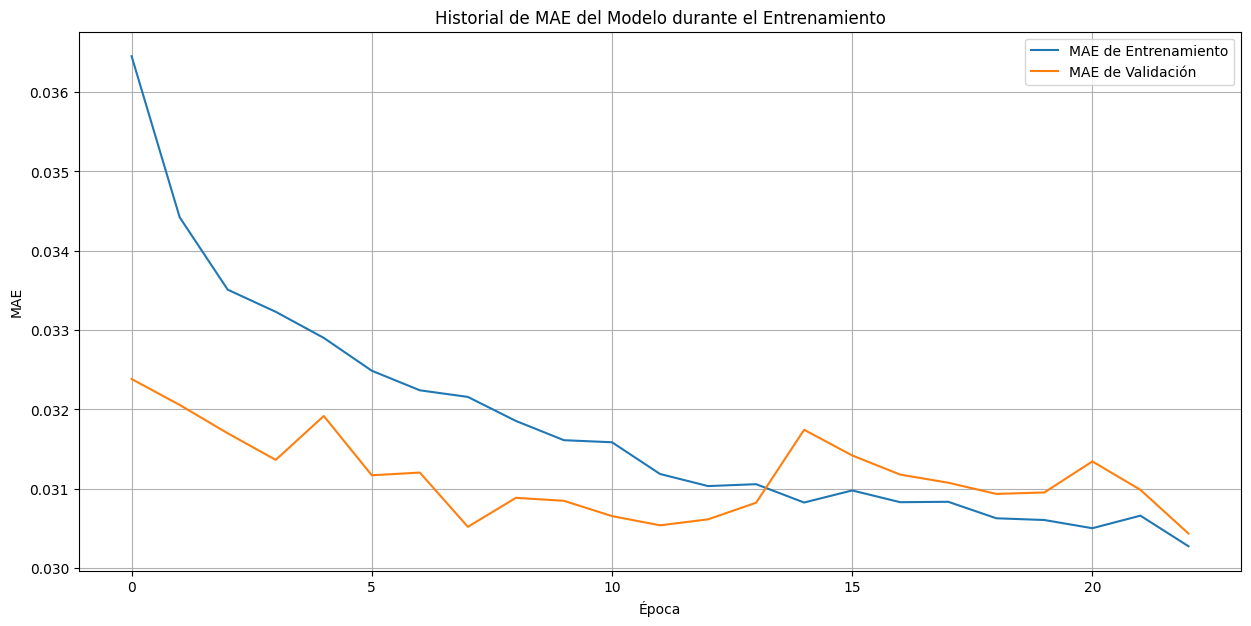


--- Guardando el modelo en: /content/drive/MyDrive/json/2024-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [12]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2024.csv')
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
print(" Cargando Modelo de 2023 para Fine-tuning con datos de 2024 ")
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2023-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero ")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación ")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs ")
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" CODIFICACIÓN DE ESTACIONES CON LABEL ENCODER Y ESCALADORES ")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base ")
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creación de Secuencias Multivariadas (Corregida) ")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32) ")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba ")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning ")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning) ")
model.summary()
print(" Configurando Callbacks para el Entrenamiento ")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017 ")
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ")
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print(" FIN DEPURACIÓN ")
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print(" FIN DEPURACIÓN DE NAN/INF ")
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba ")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento ")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo ")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba ")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2024-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path} ")
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

df_total cargado desde CSV con 159362 filas y 16 columnas.

--- Cargando Modelo de 2024 para Fine-tuning con datos de 2025 ---
Modelo '2024-Encoder-Decoder.keras' cargado exitosamente para fine-tuning.
df_total cargado desde CSV con 159362 filas y 16 columnas.
df_total ya cargado con 159362 filas y 9 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159362 entries, 0 to 159361
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fecha       159362 non-null  object 
 1   indicativo  159362 non-null  object 
 2   nombre      159362 non-null  object 
 3   provincia   159362 non-null  object 
 4   altitud     159362 non-null  int64  
 5   tmed        156004 non-null  float64
 6   prec        153706 non-null  float64
 7   tmin        156054 non-null  float64
 8   tmax        156171 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 10.9+ MB

--- Ordenando Datos Globalmente por Fecha y Estación

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_id_input    │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 50, 50)    │     45,900 │ station_id_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 55)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ station_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    188,416 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     12,900 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      5,050 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25)        │        100 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 420,155 (1.60 MB)

 Trainable params: 419,037 (1.60 MB)

 Non-trainable params: 1,118 (4.37 KB)


--- Configurando Callbacks para el Entrenamiento ---

--- Iniciando Fine-tuning del Modelo con datos de 2017 ---
Tamaño del conjunto de entrenamiento para `fit`: 82638 muestras
Tamaño del conjunto de validación para `fit`: 9183 muestras

--- DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ---
Shape de X_train_set_numeric: (82638, 50, 5)
Shape de X_train_set_station_ids: (82638, 50)
Shape de y_train_set: (82638, 1)
Shape de X_val_set_numeric: (9183, 50, 5)
Shape de X_val_set_station_ids: (9183, 50)
Shape de y_val_set: (9183, 1)
--- FIN DEPURACIÓN ---
NaNs en X_train_set_numeric: 0
Infs en X_train_set_numeric: 0
NaNs en y_train_set: 0
Infs en y_train_set: 0
NaNs en X_val_set_numeric: 0
Infs en X_val_set_numeric: 0
NaNs en y_val_set: 0
Infs en y_val_set: 0
--- FIN DEPURACIÓN DE NAN/INF ---
Epoch 1/50
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 0.0016 - val_mae: 0.0297 - learning_rate: 1.0000e-04
Epoch 2

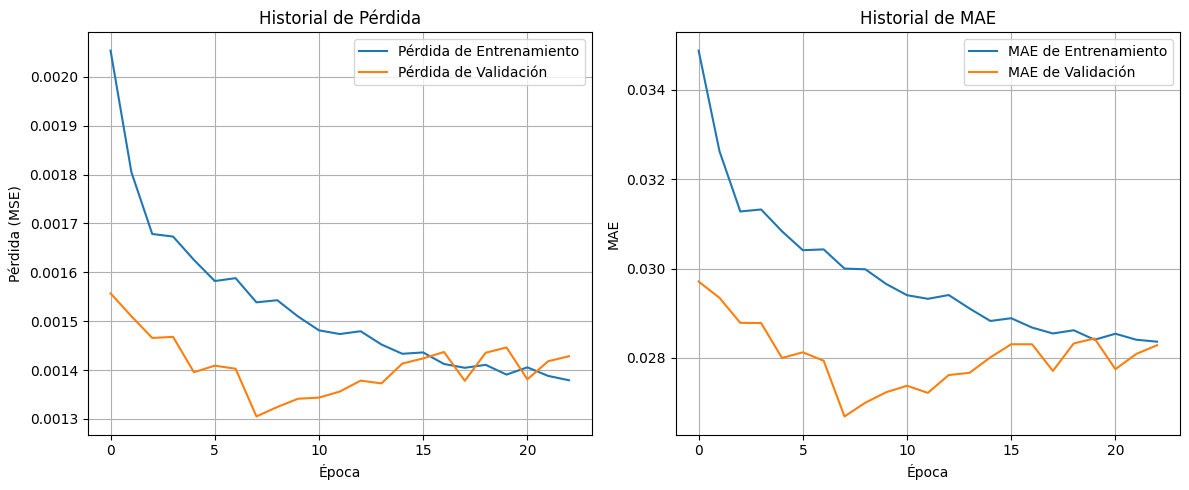


--- Realizando Predicciones de Ejemplo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Predicciones vs. Valores Reales (Temperaturas en °C):
Predicción: 16.68°C, Real: 16.00°C
Predicción: 15.41°C, Real: 16.20°C
Predicción: 16.06°C, Real: 15.20°C
Predicción: 15.12°C, Real: 15.80°C
Predicción: 14.71°C, Real: 13.40°C
Predicción: 14.74°C, Real: 14.00°C
Predicción: 16.30°C, Real: 16.60°C
Predicción: 17.89°C, Real: 17.90°C
Predicción: 18.78°C, Real: 16.60°C
Predicción: 18.88°C, Real: 19.80°C

--- Evaluación Adicional del Modelo en el Conjunto de Prueba ---
Pérdida (MSE) en el conjunto de prueba (escalada): 0.0010
Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): 0.0235
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Error Absoluto Medio (MAE) en escala original (completo): 1.13°C
Coeficiente de Determinación (R-squared) (completo): 0.9141

--- Gráfico de Predicciones vs Valores Reales (Completo) ---


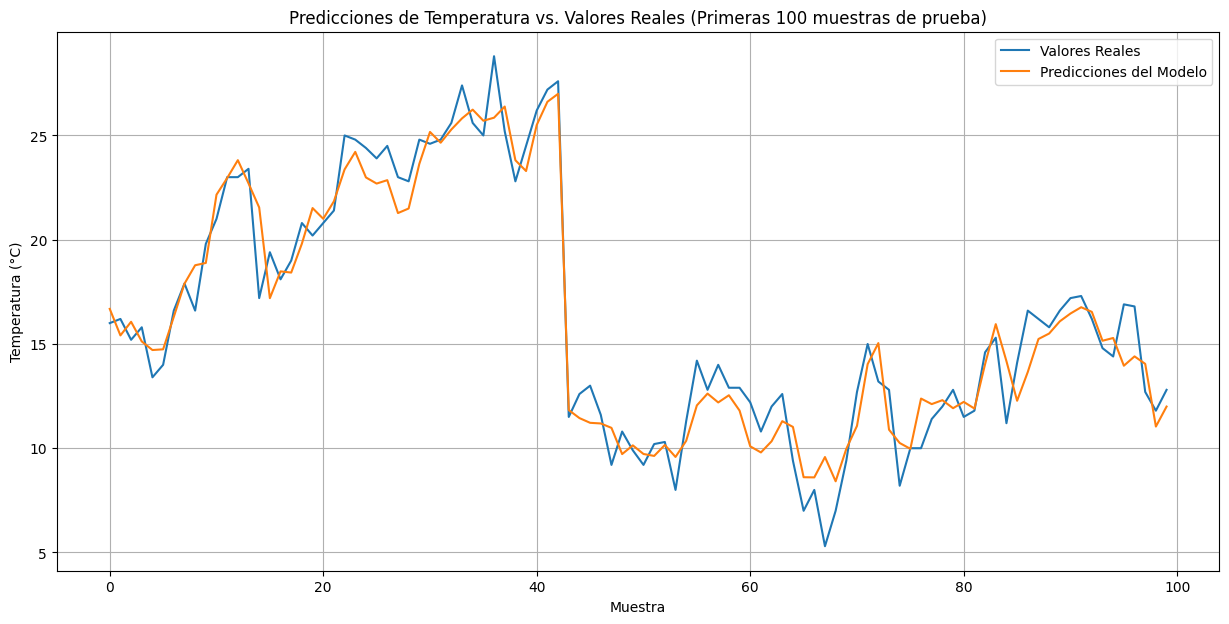


--- Gráfico de Pérdida MSE (Completo) ---


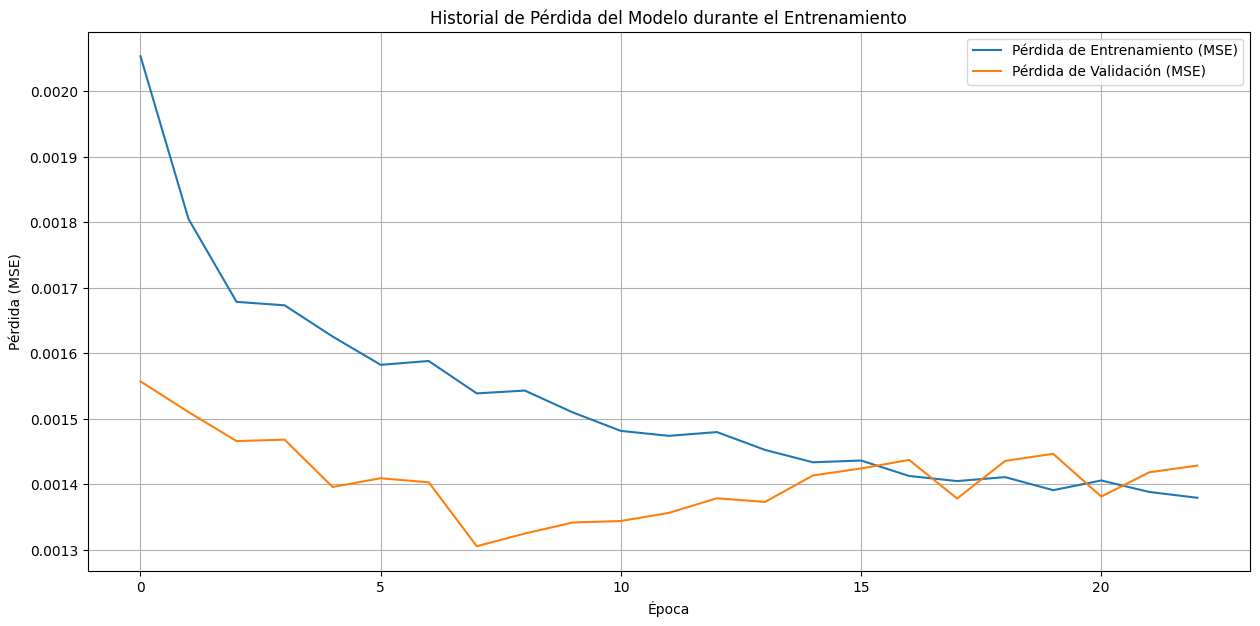


--- Gráfico MAE (Completo) ---


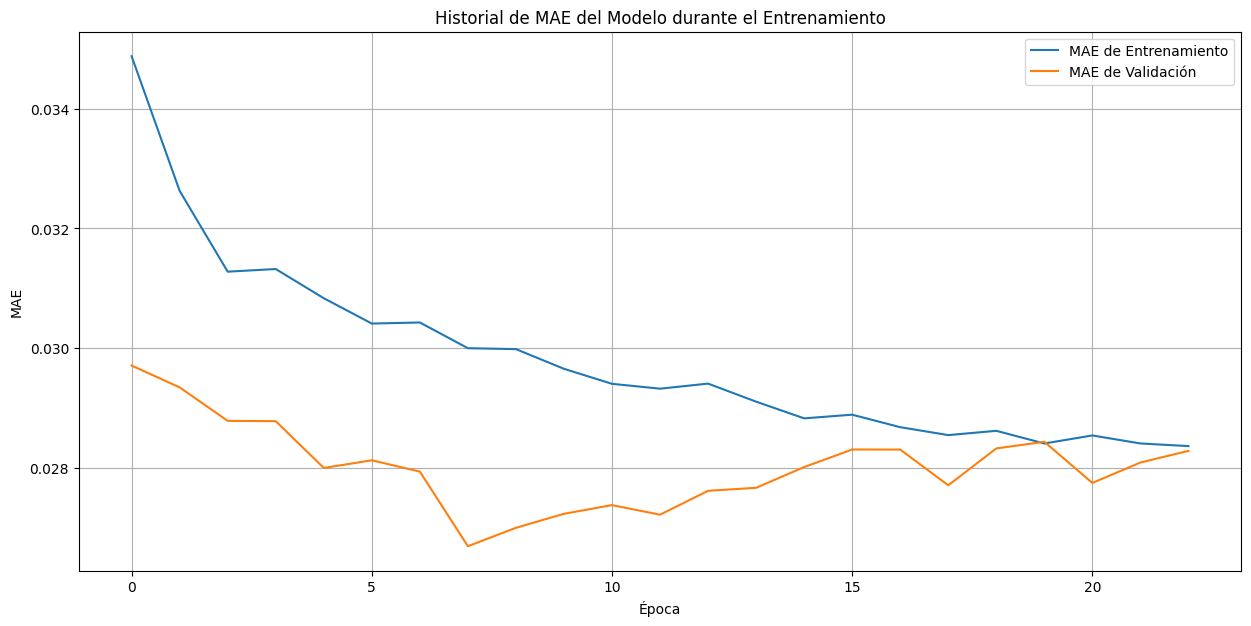


--- Guardando el modelo en: /content/drive/MyDrive/json/2025-Encoder-Decoder.keras ---
Modelo guardado exitosamente.


In [13]:
df_total = pd.read_csv('/content/drive/MyDrive/json/2025.csv')
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
print(" Cargando Modelo de 2024 para Fine-tuning con datos de 2025 ")
model_load_path = '/content/drive/MyDrive/json/'
model_load_name = '2024-Encoder-Decoder.keras'
full_model_load_path = os.path.join(model_load_path, model_load_name)
try:
    model = load_model(full_model_load_path)
    print(f"Modelo '{model_load_name}' cargado exitosamente para fine-tuning.")
except Exception as e:
    print(f"Error al cargar el modelo '{model_load_name}': {e}")
    print("Se inicializará un nuevo modelo desde cero (¡Esto no es fine-tuning!).")
    NUM_FEATURES = len(features_all)
    input_numeric = Input(shape=(TIME_STEPS, NUM_FEATURES), name='numeric_input', dtype='float32')
    input_station_id = Input(shape=(TIME_STEPS,), name='station_id_input', dtype='int32')
    EMBEDDING_DIM = 50
    embedding_layer = Embedding(input_dim=NUM_STATIONS, output_dim=EMBEDDING_DIM, name='station_embedding')(input_station_id)
    merged_inputs = tf.keras.layers.concatenate([input_numeric, embedding_layer], axis=-1)
    x = Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True))(merged_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, activation='tanh', return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(units=100, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(units=25, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(units=1, activation='linear')(x)
    model = Model(inputs=[input_numeric, input_station_id], outputs=output)
print(f"df_total cargado desde CSV con {len(df_total)} filas y {len(df_total.columns)} columnas.")
columns_to_drop_exact = [
    'horatmin', 'horatmax',
    'hrmax', 'horahrmax', 'hrmin', 'horahrmin', 'hrmedia',
    'dir', 'velmedia', 'racha', 'horaracha',
    'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'sol'
]
df_total = df_total.drop(columns=[col for col in columns_to_drop_exact if col in df_total.columns], errors='ignore')
TIME_STEPS = 50
print(f"df_total ya cargado con {df_total.shape[0]} filas y {df_total.shape[1]} columnas.")
df_total.info()
print(" Ordenando Datos Globalmente por Fecha y Estación ")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.sort_values(by=['indicativo', 'fecha']).reset_index(drop=True)
print(" Procesando Características y Manejando NaNs ")
features_all = ['tmed', 'prec', 'tmin', 'tmax', 'altitud']
features_all = [col for col in features_all if col in df_total.columns]
target_feature_name = 'tmed'
if target_feature_name not in features_all:
    raise ValueError(f"La columna objetivo '{target_feature_name}' no está en las características disponibles.")
df_processed = df_total[features_all + ['indicativo']].copy()
cols_to_convert_objects = [col for col in features_all if df_processed[col].dtype == 'object']
print(f"Columnas numéricas detectadas como tipo 'object' para conversión: {cols_to_convert_objects}")
for col in cols_to_convert_objects:
    df_processed.loc[:, col] = df_processed[col].astype(str).str.replace(',', '.', regex=False)
    df_processed.loc[:, col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.loc[:, col] = df_processed[col].astype(float)
    print(f"Columna '{col}' convertida a numérico. dtype actual: {df_processed[col].dtype}")
nan_check_numeric = df_processed[features_all].isnull().sum()
if nan_check_numeric.sum() > 0:
    print("\n¡Advertencia! Se encontraron NaNs en las características numéricas después de la conversión:")
    print(nan_check_numeric[nan_check_numeric > 0])
    for col in features_all:
        if df_processed[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                median_val = df_processed[col].median()
                df_processed.loc[:, col] = df_processed[col].fillna(median_val)
                print(f"NaNs en '{col}' rellenados con la mediana ({median_val:.2f}).")
            else:
                print(f"ERROR CRÍTICO: La columna '{col}' NO ES NUMÉRICA AÚN. No se pudo rellenar NaNs.")
                df_processed.dropna(subset=[col], inplace=True)
final_nan_numeric_check = df_processed[features_all].isnull().sum()
if final_nan_numeric_check.sum() > 0:
    print("\n¡ADVERTENCIA CRÍTICA FINAL! Aún quedan NaNs en características numéricas:")
    print(final_nan_numeric_check[final_nan_numeric_check > 0])
    df_processed.dropna(subset=features_all, inplace=True)
    print(f"Filas con NaNs restantes eliminadas. Nuevas dimensiones de df_processed: {df_processed.shape}")
df_processed = df_processed.reset_index(drop=True)
print(" CODIFICACIÓN DE ESTACIONES CON LABEL ENCODER Y ESCALADORES (CARGAR OBJETOS BASE) ")
try:
    label_encoder = load('/content/drive/MyDrive/json/label_encoder_global_all_stations.joblib')
    scaler_X = load('/content/drive/MyDrive/json/scaler_X_base.joblib')
    scaler_y = load('/content/drive/MyDrive/json/scaler_y_base.joblib')
    print("LabelEncoder global y Scalers base cargados exitosamente.")
except Exception as e:
    print(f"ERROR CRÍTICO: No se pudieron cargar el LabelEncoder o los Scalers base. {e}")
    print("Por favor, asegúrate de haber ejecutado los scripts anteriores para crearlos.")
    raise
NUM_STATIONS = len(label_encoder.classes_)
print(f"Número total de estaciones únicas (del encoder global): {NUM_STATIONS}")
df_processed.loc[:, 'indicativo_encoded'] = label_encoder.transform(df_processed['indicativo'])
print("Columna 'indicativo' codificada con el LabelEncoder global.")
print(" Escalando Datos Numéricos (X e Y por separado) usando Scalers Base ")
y_original_unscaled_all = df_processed[target_feature_name].values.reshape(-1, 1)
print(f"Valores originales de '{target_feature_name}' antes de escalar Y: Min={np.min(y_original_unscaled_all):.2f}, Max={np.max(y_original_unscaled_all):.2f}")
y_all_scaled = scaler_y.transform(y_original_unscaled_all)
X_features_unscaled_all = df_processed[features_all].values
X_all_scaled = scaler_X.transform(X_features_unscaled_all)
print(" Creación de Secuencias Multivariadas (Corregida) ")
def create_sequences(df_data, X_scaled_array, y_scaled_array, station_ids_encoded_array, time_steps):
    X_numeric_seq, X_station_id_seq, y_target_seq = [], [], []
    grouped = df_data.groupby('indicativo')
    for station_name, group_df in grouped:
        start_idx_group = group_df.index[0]
        end_idx_group = group_df.index[-1] + 1
        current_station_X_scaled = X_scaled_array[start_idx_group : end_idx_group]
        current_station_y_scaled = y_scaled_array[start_idx_group : end_idx_group]
        current_station_ids_encoded = station_ids_encoded_array[start_idx_group : end_idx_group]
        if not (len(current_station_X_scaled) == len(current_station_y_scaled) == len(current_station_ids_encoded)):
            print(f"Advertencia: Desalineación de datos en estación {station_name}. Se omitirá.")
            continue
        if len(current_station_X_scaled) >= time_steps + 1:
            for i in range(len(current_station_X_scaled) - time_steps):
                X_numeric_seq.append(current_station_X_scaled[i:(i + time_steps), :])
                X_station_id_seq.append(current_station_ids_encoded[i:(i + time_steps)])
                y_target_seq.append(current_station_y_scaled[i + time_steps])
    return np.array(X_numeric_seq), np.array(X_station_id_seq), np.array(y_target_seq)
X_numeric_raw, X_station_ids_raw, y_scaled = create_sequences(
    df_processed, X_all_scaled, y_all_scaled, df_processed['indicativo_encoded'].values, TIME_STEPS
)
print(" Convirtiendo datos a float32 ")
X_numeric_raw = X_numeric_raw.astype(np.float32)
X_station_ids_raw = X_station_ids_raw.astype(np.int32)
y_scaled = y_scaled.astype(np.float32)
print(" Diagnóstico de Datos Finales (en float32) ")
print(f"Dimensiones de X numéricas (secuencias de entrada): {X_numeric_raw.shape}")
print(f"Dimensiones de X IDs de estación (secuencias de entrada): {X_station_ids_raw.shape}")
print(f"Dimensiones de y (valores objetivo escalados): {y_scaled.shape}")
if y_scaled.size > 0:
    print(f"Mínimo de 'y' escalado: {np.min(y_scaled):.6f}")
    print(f"Máximo de 'y' escalado: {np.max(y_scaled):.6f}")
    print(f"Media de 'y' escalado: {np.mean(y_scaled):.6f}")
    print(f"Desviación estándar de 'y' escalado: {np.std(y_scaled):.6f}")
    unique_y_values_scaled = np.unique(y_scaled)
    print(f"Cantidad de valores únicos en 'y' escalado: {len(unique_y_values_scaled)}")
    if len(unique_y_values_scaled) <= 10:
        print(f"Valores únicos en 'y' (escalados): {unique_y_values_scaled.flatten()}")
    else:
        print(f"Primeros 10 valores únicos en 'y' (escalados): {unique_y_values_scaled[:10].flatten()}")
    try:
        y_original_sample = scaler_y.inverse_transform(y_scaled[:10]).flatten()
        print(f"Primeros 10 valores de 'y' desescalados (¡AHORA DEBERÍAN SER REALES!): {y_original_sample}")
    except Exception as e:
        print(f"No se pudo desescalar una muestra de 'y' para verificación: {e}")
else:
    print("El array 'y_scaled' está vacío después del preprocesamiento.")
if X_numeric_raw.shape[0] > 0 and X_numeric_raw.shape[2] == len(features_all):
    print(f"Mínimo de 'tmed' en X (escalado, posición 0): {np.min(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
    print(f"Máximo de 'tmed' en X (escalado, posición 0): {np.max(X_numeric_raw[:, :, features_all.index('tmed')]):.6f}")
else:
    print("El array 'X_numeric_raw' está vacío o no tiene la forma esperada para el diagnóstico.")
print(" Dividiendo Datos en Conjuntos de Entrenamiento y Prueba ")
X_train_full_numeric, X_test_numeric, y_train_full, y_test = train_test_split(
    X_numeric_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full_station_ids, X_test_station_ids, _, _ = train_test_split(
    X_station_ids_raw, y_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_full = [X_train_full_numeric, X_train_full_station_ids]
X_test = [X_test_numeric, X_test_station_ids]
print(" Compilando el Modelo para Fine-tuning ")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='mse',
              metrics=['mae'])
print(" Resumen del Modelo Cargado (para Fine-tuning) ")
model.summary()
print(" Configurando Callbacks para el Entrenamiento ")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)
print(" Iniciando Fine-tuning del Modelo con datos de 2017 ")
val_split_ratio = 0.10
split_index = int(X_train_full[0].shape[0] * (1 - val_split_ratio))
X_train_set_numeric, X_val_set_numeric = X_train_full[0][:split_index], X_train_full[0][split_index:]
X_train_set_station_ids, X_val_set_station_ids = X_train_full[1][:split_index], X_train_full[1][split_index:]
y_train_set, y_val_set = y_train_full[:split_index], y_train_full[split_index:]
print(f"Tamaño del conjunto de entrenamiento para `fit`: {len(X_train_set_numeric)} muestras")
print(f"Tamaño del conjunto de validación para `fit`: {len(X_val_set_numeric)} muestras")
print(" DEPURACIÓN: Verificando formas de los conjuntos de entrenamiento y validación ANTES del fit ")
print(f"Shape de X_train_set_numeric: {X_train_set_numeric.shape}")
print(f"Shape de X_train_set_station_ids: {X_train_set_station_ids.shape}")
print(f"Shape de y_train_set: {y_train_set.shape}")
print(f"Shape de X_val_set_numeric: {X_val_set_numeric.shape}")
print(f"Shape de X_val_set_station_ids: {X_val_set_station_ids.shape}")
print(f"Shape de y_val_set: {y_val_set.shape}")
print(" FIN DEPURACIÓN ")
print(f"NaNs en X_train_set_numeric: {np.sum(np.isnan(X_train_set_numeric))}")
print(f"Infs en X_train_set_numeric: {np.sum(np.isinf(X_train_set_numeric))}")
print(f"NaNs en y_train_set: {np.sum(np.isnan(y_train_set))}")
print(f"Infs en y_train_set: {np.sum(np.isinf(y_train_set))}")
print(f"NaNs en X_val_set_numeric: {np.sum(np.isnan(X_val_set_numeric))}")
print(f"Infs en X_val_set_numeric: {np.sum(np.isinf(X_val_set_numeric))}")
print(f"NaNs en y_val_set: {np.sum(np.isnan(y_val_set))}")
print(f"Infs en y_val_set: {np.sum(np.isinf(y_val_set))}")
print(" FIN DEPURACIÓN DE NAN/INF ")
history = model.fit(
    [X_train_set_numeric, X_train_set_station_ids], y_train_set,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_set_numeric, X_val_set_station_ids], y_val_set),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(" Evaluando el Modelo en el Conjunto de Prueba ")
loss_scaled, mae_scaled = model.evaluate(X_test, y_test, verbose=0)
mae_original_scale = mae_scaled * (scaler_y.data_max_[0] - scaler_y.data_min_[0])
print(f"Pérdida (MSE) en el conjunto de prueba (escalada): {loss_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae_scaled:.4f}")
print(f"Error Absoluto Medio (MAE) en escala original: {mae_original_scale:.2f}°C")
print(" Visualizando Métricas de Entrenamiento ")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Historial de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" Realizando Predicciones de Ejemplo ")
num_predictions_to_show = min(10, X_test[0].shape[0])
X_sample_numeric = X_test[0][:num_predictions_to_show]
X_sample_station_ids = X_test[1][:num_predictions_to_show]
y_actual_scaled = y_test[:num_predictions_to_show]
y_predicted_scaled = model.predict([X_sample_numeric, X_sample_station_ids])
y_predicted_original = scaler_y.inverse_transform(y_predicted_scaled)
y_actual_original = scaler_y.inverse_transform(y_actual_scaled)
print("Predicciones vs. Valores Reales (Temperaturas en °C):")
for i in range(num_predictions_to_show):
    print(f"Predicción: {y_predicted_original[i][0]:.2f}°C, Real: {y_actual_original[i][0]:.2f}°C")
print(" Evaluación Adicional del Modelo en el Conjunto de Prueba ")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE) en el conjunto de prueba (escalada): {loss:.4f}')
print(f'Error Absoluto Medio (MAE) en el conjunto de prueba (escalada): {mae:.4f}')
predictions_scaled_full = model.predict(X_test)
predictions_original_full = scaler_y.inverse_transform(predictions_scaled_full)
y_test_original_full = scaler_y.inverse_transform(y_test)
mae_original_full = mean_absolute_error(y_test_original_full, predictions_original_full)
print(f'Error Absoluto Medio (MAE) en escala original (completo): {mae_original_full:.2f}°C')
r2_full = r2_score(y_test_original_full, predictions_original_full)
print(f'Coeficiente de Determinación (R-squared) (completo): {r2_full:.4f}')
print(" Gráfico de Predicciones vs Valores Reales (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(y_test_original_full[:100], label='Valores Reales')
plt.plot(predictions_original_full[:100], label='Predicciones del Modelo')
plt.title('Predicciones de Temperatura vs. Valores Reales (Primeras 100 muestras de prueba)')
plt.xlabel('Muestra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico de Pérdida MSE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Historial de Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print(" Gráfico MAE (Completo) ")
plt.figure(figsize=(15, 7))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Historial de MAE del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()
model_save_path = '/content/drive/MyDrive/json/'
model_name = '2025-Encoder-Decoder.keras'
os.makedirs(model_save_path, exist_ok=True)
full_model_path = os.path.join(model_save_path, model_name)
print(f" Guardando el modelo en: {full_model_path} ")
try:
    model.save(full_model_path)
    print("Modelo guardado exitosamente.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")